# WhatPulse Keypress Stats Analyzer

By Kenneth Burchfiel

Released under the MIT license

*(I am not affiliated with WhatPulse (https://whatpulse.org) but highly recommend trying out the program, which I've used since September 2008. You can find my online WhatPulse page here: https://whatpulse.org/KBurchfiel)*

This script allows you to perform various analyses of your WhatPulse typing stats. It does so by accessing the local WhatPulse database on your computer (along with other copies of databases you might want to include); reading this data into Pandas DataFrames, and then summarizing and graphing that data. The output of the script includes:

1. Rolling average calculations at the 7-, 28-, and 365-day level
2. Percentile and rank calculations
3. Weekly and hourly keypress stats
4. Static (.png) and interactive (.html) keypress charts

By converting this notebook into a Python file and then instructing your computer to run it on an hourly basis, you can also keep track of how much you're typing during your day. Which is sort of nerdy, to be honest. But so is this whole program ;) 

I'll first import a number of packages that the program will use:

In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import numpy as np
from datetime import date
import statsmodels.api as sm
from scipy.stats import percentileofscore
import plotly.express as px
import kaleido
from IPython.display import Image
import datetime

I'll next define the names of folders that will store various outputs, along with default settings to use when converting interactive charts to static .png files:

In [2]:
static_graphs_folder = 'graphs/static/'
interactive_graphs_folder = 'graphs/interactive/'
data_folder = 'data'

default_image_height = 540
default_aspect_ratio = 16 / 9 # Standard HD/UHD aspect ratio
default_image_width = default_image_height * default_aspect_ratio
default_image_scale = 5 # Creating a smaller graph (e.g. one 540 pixels 
# in height) and then scaling it helps keep the text a bit larger.

## Importing Whatpulse data

In order to analyze my WhatPulse data, I'll first need to import it from my local Whatpulse SQLite database. I'll also import a copy of the Whatpulse SQLite database stored on my old laptop (so that my analysis doesn't have to be limited to my current computer's keypress data.)

You'll of course need to update the following cell with the path(s) to your own WhatPulse database(s).

Note: if you want to run this program on your own, but don't have access to a WhatPulse database, you can still run this program (assuming you've downloaded or cloned it from GitHub). Skip ahead to the line where I read in 

In [3]:
database_paths_list = ['C:/Users/kburc/AppData/Local/whatpulse/whatpulse.db', 
'C:/Users/kburc/D1V1/Documents/whatpulse_database_backups/a13r2_whatpulse.db',
'G:/My Drive/whatpulse_database_backups/linux_whatpulse.db'] 
# Note that the first path is to my computer's active database, 
# whereas additional paths point towards copies of databases from 
# other computers that I have used.

The following function analyzes each database's  table at either the daily or hourly level.

In [4]:
def generate_keypress_totals(database_path, level = 'daily'):
    '''The level argument can be 'daily', in which case the DataFrame
    returned by the function will show daily keypress totals, or 'hourly',
    which will preserve the hourly keypress totals in the original database.'''
    file_name = database_path.split('/')[-1] # Retrieves the final element
    # of the path (e.g. the file name)
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine(
        'sqlite:///'+database_path) 
    # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", 
    con = sqlalchemy_sqlite_engine) # Simply reads all of the data from this 
    # Capitalizing column names so that less renaming will be necessary
    # when creating graphs:
    df_keypresses.columns = [column.title() for column in df_keypresses.columns]

    # table into a Pandas DataFrame
    df_keypresses = df_keypresses.query("Day != '0000-00-00'").copy() # Removes
    # this blank date value from the database if it happens to be there
    if level == 'daily': # In this case, we'll want to combine hourly keypress
        # totals into a single row for each day
        df_keypresses = df_keypresses.pivot_table(
            index = 'Day', values = 'Count', aggfunc = 'sum')
        df_keypresses.sort_values('Day', inplace = True)
    elif level == 'hourly': # The original data is already displayed 
        # at the hourly level, so there's no need for a pivot_table() call.
        df_keypresses.sort_values(['Day', 'Hour'], inplace = True)
    else:
        raise ValueError("Unrecognized level argument passed to function.")
    df_keypresses.rename(columns={'Count':'Keypresses'},inplace=True)  
    return df_keypresses

I'll now run generate_keypress_totals in order to create a record of daily keypresses for both my current database and a copy of a past database. (I'll look at hourly keypress totals later on.)

In [5]:
keypress_databases_list = []

for path in database_paths_list: # This loop creates a DataFrame for
    # each WhatPulse database stored in database_paths_list.
    # print("Now loading:",path)
    keypress_databases_list.append(generate_keypress_totals(
        path, level = 'daily'))

# I'll now combine these tables into a single DataFrame.
df_combined_daily_keypresses = pd.concat(
    [keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)

# At this point, my copy of df_combined_daily_keypresses has multiple
# entries for days in which I logged keys on multiple operating systems.
# Therefore, the following line groups these entries into a single row
# for each date.
df_combined_daily_keypresses = df_combined_daily_keypresses.reset_index(
).pivot_table(index = 'Day', values = 'Keypresses', aggfunc = 'sum')
df_combined_daily_keypresses.index = pd.to_datetime(
    df_combined_daily_keypresses.index)

df_combined_daily_keypresses.to_csv('data/df_combined_daily_keypresses.csv')
df_combined_daily_keypresses

Keypresses
Day                   
2020-09-21       19081
2020-09-22       32771
2020-09-23       32065
2020-09-24       34698
2020-09-25       47038
...                ...
2023-06-13       23745
2023-06-14       50339
2023-06-15       45835
2023-06-16       40815
2023-06-17       11847

[948 rows x 1 columns]

The following line rebuilds df_combined_daily_keypresses using a copy of the DataFrame that got exported to a .csv file earlier on. This cell allows allow you to run this script even if you don't have your own WhatPulse database.

In [6]:
df_combined_daily_keypresses = pd.read_csv(
    'data/df_combined_daily_keypresses.csv', index_col='Day')
# The following line makes the index compatible with
# date operations that the following code block will perform.
df_combined_daily_keypresses.index = pd.to_datetime(
df_combined_daily_keypresses.index)
df_combined_daily_keypresses

Keypresses
Day                   
2020-09-21       19081
2020-09-22       32771
2020-09-23       32065
2020-09-24       34698
2020-09-25       47038
...                ...
2023-06-13       23745
2023-06-14       50339
2023-06-15       45835
2023-06-16       40815
2023-06-17       11847

[948 rows x 1 columns]

The following code block fills in the DataFrame with missing dates (e.g. dates in which I did not have any keypresses). I want to add in those missing dates so that I can calculate more accurate rolling keypress averages.

In [7]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) 
# https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(
    full_date_range, fill_value=0) 
# See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html

df_combined_daily_keypresses.index.name = 'Date'
df_combined_daily_keypresses.reset_index(inplace=True) 

Now that I have a more complete daily keypress history, I can begin performing analyses on this data. First, I will use the rolling() function within Pandas to calculate 7-, 28-, and 365-day moving averages. Next, I will use the Series.rank() function twice to (1) calculate the percentile of each keypress and (2) determine each keypress's rank within the entire DataFrame.

In [8]:
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses[
    'Keypresses'].rolling(7).mean()
df_combined_daily_keypresses['28_day_ma'] = df_combined_daily_keypresses[
    'Keypresses'].rolling(28).mean() 
# I switched from a 30-day MA to a 28-day MA because my average keypresses vary 
# significantly by weekday, meaning that a 30-day average would be skewed by 
# the number of Saturdays and Sundays present in the data.
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses[
    'Keypresses'].rolling(365).mean()

df_combined_daily_keypresses['percentile'] = 100*df_combined_daily_keypresses[
    'Keypresses'].rank(pct=True)
# The pct=True argument generates percentile values for each keypress value.
df_combined_daily_keypresses['rank'] = df_combined_daily_keypresses[
    'Keypresses'].rank(ascending = False)
# Ascending = False instructs the function to assign the lowest number 
# (e.g. 1) to the highest value.
# If two dates are tied, the rank may end in a 0.5. That's why these ranks 
# appear as floats but not integers. 
df_combined_daily_keypresses

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
0   2020-09-21       19081           NaN           NaN           NaN   
1   2020-09-22       32771           NaN           NaN           NaN   
2   2020-09-23       32065           NaN           NaN           NaN   
3   2020-09-24       34698           NaN           NaN           NaN   
4   2020-09-25       47038           NaN           NaN           NaN   
..         ...         ...           ...           ...           ...   
995 2023-06-13       23745  18202.571429  24115.464286  20799.172603   
996 2023-06-14       50339  21198.428571  24620.357143  20934.254795   
997 2023-06-15       45835  23978.000000  25124.642857  21042.520548   
998 2023-06-16       40815  29523.142857  25422.285714  21048.158904   
999 2023-06-17       11847  31215.571429  25211.785714  21031.334247   

     percentile   rank  
0         40.30  598.0  
1         67.50  326.0  
2         65.90  342.0  
3         70.55  295.5  
4         88.50  116.0  
..          ...    ...  
995       48.90  512.0  
996       91.80   83.0  
997       87.40  127.0  
998       80.70  194.0  
999       28.10  720.0  

[1000 rows x 7 columns]

Next, I'll add in weekdays using the Series.map() function within Pandas.

In [9]:
weekday_dict = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',
5:'Saturday',6:'Sunday'}
# weekday numbers in Python begin with 0 for Monday and end with 6 for Sunday. 
# See https://docs.python.org/3/library/datetime.html#datetime.date.weekday
weekday_dict

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday',
 6: 'Sunday'}

The following cell adds a 'Weekday' column to the DataFrame by (1) calculating the numerical weekday values for each date in the 'Date' column, then (2) using weekday_dict to map these numerical values to the weekday names. 

In [10]:
df_combined_daily_keypresses['Weekday'] = df_combined_daily_keypresses[
    'Date'].dt.weekday.map(weekday_dict)

Here are my daily keypress statistics for the last 10 days. Note the presence of the moving average, percentile, rank, and weekday columns.

In [11]:
df_combined_daily_keypresses.tail(10)

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
990 2023-06-08       26378  26142.714286  24598.321429  20701.928767   
991 2023-06-09        1999  21335.428571  23868.785714  20635.723288   
992 2023-06-10           0  20283.428571  23562.821429  20623.246575   
993 2023-06-11       14647  18180.142857  24085.928571  20663.087671   
994 2023-06-12       31281  18811.857143  24450.571429  20748.789041   
995 2023-06-13       23745  18202.571429  24115.464286  20799.172603   
996 2023-06-14       50339  21198.428571  24620.357143  20934.254795   
997 2023-06-15       45835  23978.000000  25124.642857  21042.520548   
998 2023-06-16       40815  29523.142857  25422.285714  21048.158904   
999 2023-06-17       11847  31215.571429  25211.785714  21031.334247   

     percentile   rank    Weekday  
990       54.70  454.0   Thursday  
991       13.30  868.0     Friday  
992        2.85  972.5   Saturday  
993       32.20  679.0     Sunday  
994       64.20  359.0     Monday  
995       48.90  512.0    Tuesday  
996       91.80   83.0  Wednesday  
997       87.40  127.0   Thursday  
998       80.70  194.0     Friday  
999       28.10  720.0   Saturday

# Data Analysis

I'll start my data analysis by calculating some summary statistics. In the output below, 'count' shows the number of days since the earliest entry in my database, rather than the number of days for which I have keypress data (as the table also includes days without any keypresses).

In [12]:
df_combined_daily_keypresses['Keypresses'].describe()

count     1000.000000
mean     24787.483000
std      17710.795036
min          0.000000
25%       9326.500000
50%      24362.000000
75%      36859.250000
max      90447.000000
Name: Keypresses, dtype: float64

Next, I'll calculate my top 50 daily keypress totals. Note that the top-ranked date has a rank of 1 and a percentile of 100.

In [13]:
df_max_keypresses = df_combined_daily_keypresses.sort_values(
    'Keypresses', ascending = False).reset_index(drop=True)
df_max_keypresses.insert(0, 'Rank', df_max_keypresses.index+1)
keypress_difference_list = [
    df_max_keypresses.iloc[i]['Keypresses'] - df_max_keypresses.iloc[i+1][
        'Keypresses'] for i in range(len(df_max_keypresses) -1 )]
# The above list comprehension calculates the difference 
# between each row and the row below it. This isn't possible for the final row,
# so I'll instead append a np.Nan to it.)
keypress_difference_list.append(np.NaN)
df_max_keypresses['difference_from_lower_rank'] = keypress_difference_list
df_max_keypresses.head(50)

Rank       Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
0      1 2022-12-05       90447  34728.714286  26518.821429  20476.994521   
1      2 2021-02-22       77753  47983.000000  41390.857143           NaN   
2      3 2020-11-23       76313  50377.571429  39924.107143           NaN   
3      4 2020-11-19       75444  47285.571429  37945.892857           NaN   
4      5 2021-11-09       73788  37843.285714  30462.071429  29584.802740   
5      6 2022-05-03       72910  30511.428571  28489.285714  24401.624658   
6      7 2021-02-08       70591  30177.428571  34437.357143           NaN   
7      8 2021-04-06       68313  40455.857143  40719.178571           NaN   
8      9 2021-02-15       67930  46174.571429  40268.535714           NaN   
9     10 2020-11-30       67533  20747.428571  36843.714286           NaN   
10    11 2021-02-17       67505  45946.571429  40801.607143           NaN   
11    12 2021-10-12       66517  39971.285714  36729.892857  29886.202740   
12    13 2021-10-14       65935  46708.142857  37694.500000  30001.038356   
13    14 2021-09-23       65907  33891.142857  27215.107143  30006.980822   
14    15 2021-09-27       65464  35955.714286  29346.285714  29877.052055   
15    16 2021-01-25       64903  43493.714286  27181.714286           NaN   
16    17 2020-10-01       64873  41882.285714           NaN           NaN   
17    18 2023-05-31       64683  26243.000000  21224.750000  20534.572603   
18    19 2022-08-22       63149  23130.428571  21345.785714  22784.887671   
19    20 2021-10-26       62922  30820.000000  37036.107143  29899.287671   
20    21 2021-04-07       62668  41278.000000  40999.857143           NaN   
21    22 2022-04-26       62596  31803.714286  29291.607143  23983.284932   
22    23 2021-02-19       62473  47705.571429  41579.714286           NaN   
23    24 2022-05-26       62030  21439.571429  20150.964286  23948.786301   
24    25 2020-12-15       61969  44707.000000  35868.785714           NaN   
25    26 2020-12-03       61437  36799.571429  36592.642857           NaN   
26    27 2022-04-25       61200  28113.428571  28472.321429  23845.347945   
27    28 2022-01-21       60953  38414.857143  17726.821429  27924.994521   
28    29 2020-10-08       60890  42957.571429           NaN           NaN   
29    30 2021-09-22       60820  31844.285714  25305.500000  29914.263014   
30    31 2021-03-25       60758  42687.000000  33748.321429           NaN   
31    32 2022-03-23       60708  18780.428571  12933.750000  24456.224658   
32    33 2020-11-17       60147  42827.000000  36111.750000           NaN   
33    34 2021-03-30       59733  44573.285714  36193.071429           NaN   
34    35 2021-10-05       59511  41257.000000  35278.321429  29834.556164   
35    36 2021-02-01       58958  41228.428571  35547.750000           NaN   
36    37 2021-01-22       58872  32598.142857  23012.785714           NaN   
37    38 2021-03-24       58764  37907.142857  32834.714286           NaN   
38    39 2021-12-06       58253  28883.571429  27414.107143  28866.978082   
39    40 2022-01-13       58190  24615.000000  10116.392857  27780.265753   
40    41 2021-10-13       58065  43126.857143  37181.785714  29952.904110   
41    42 2022-10-13       57914  27980.285714  17756.071429  20765.580822   
42    43 2020-11-04       57390  28840.285714  33667.428571           NaN   
43    44 2021-10-11       57380  38970.428571  36170.892857  29777.947945   
44    45 2021-12-14       57328  24989.285714  25229.357143  28616.687671   
45    46 2021-03-31       56913  44308.857143  38024.535714           NaN   
46    47 2023-04-10       56877  27932.857143  28698.142857  21789.172603   
47    48 2021-03-22       56792  37541.857143  31575.607143           NaN   
48    49 2020-11-18       56454  44114.285714  36638.392857           NaN   
49    50 2021-03-09       56342  22351.428571  35691.178571           NaN   

    percentile  rank    Weekday  difference_from_lower_rank  
0        100.0

Next, I'll create a visualization of these 50 dates. I will use Plotly instead of Matplotlib so that I can create both interactive (.html) and static (.png) versions of each chart. The static versions are easier to share, but the interactive versions are easier to analyze, as you can hover over the chart to get more information and zoom in on areas of particular interest.

First, I'll create a function that will make it easier to save .html and .png versions of these charts:

In [14]:
def save_chart(fig, file_name, 
interactive_graphs_folder = interactive_graphs_folder, 
static_graphs_folder = static_graphs_folder):
    '''Saves a Plotly figure as a .HTML and .PNG file.
    fig: The Plotly figure to save.
    file_name: The filename to use. Don't include the extension.'''
    fig.write_html(
        interactive_graphs_folder+'/'+file_name+'.html')
    # Saving the interactive chart to a .png file:
    fig.write_image(
        static_graphs_folder+'/'+file_name+'.png',
        width = default_image_width, height = default_image_height,
        scale = default_image_scale)

In [15]:
# Generating the interactive chart:
fig_max_keypresses = px.bar(df_max_keypresses.head(50), 
x = 'Rank', y = 'Keypresses', title = 'Top 50 Daily Keypress Totals', 
text = 'Keypresses')

save_chart(fig_max_keypresses, 'top_50_keypresses')

Here's a look at the chart:

*Note: this and other .html-based charts will probably not display for you within GitHub. In order to view them, you will need to download the files from GitHub (e.g. by cloning them) and view them on your computer.*

In [16]:
fig_max_keypresses

Here's a copy of the static chart in case the .html chart above did not load for you: (I'll also display static versions of later charts as well.)

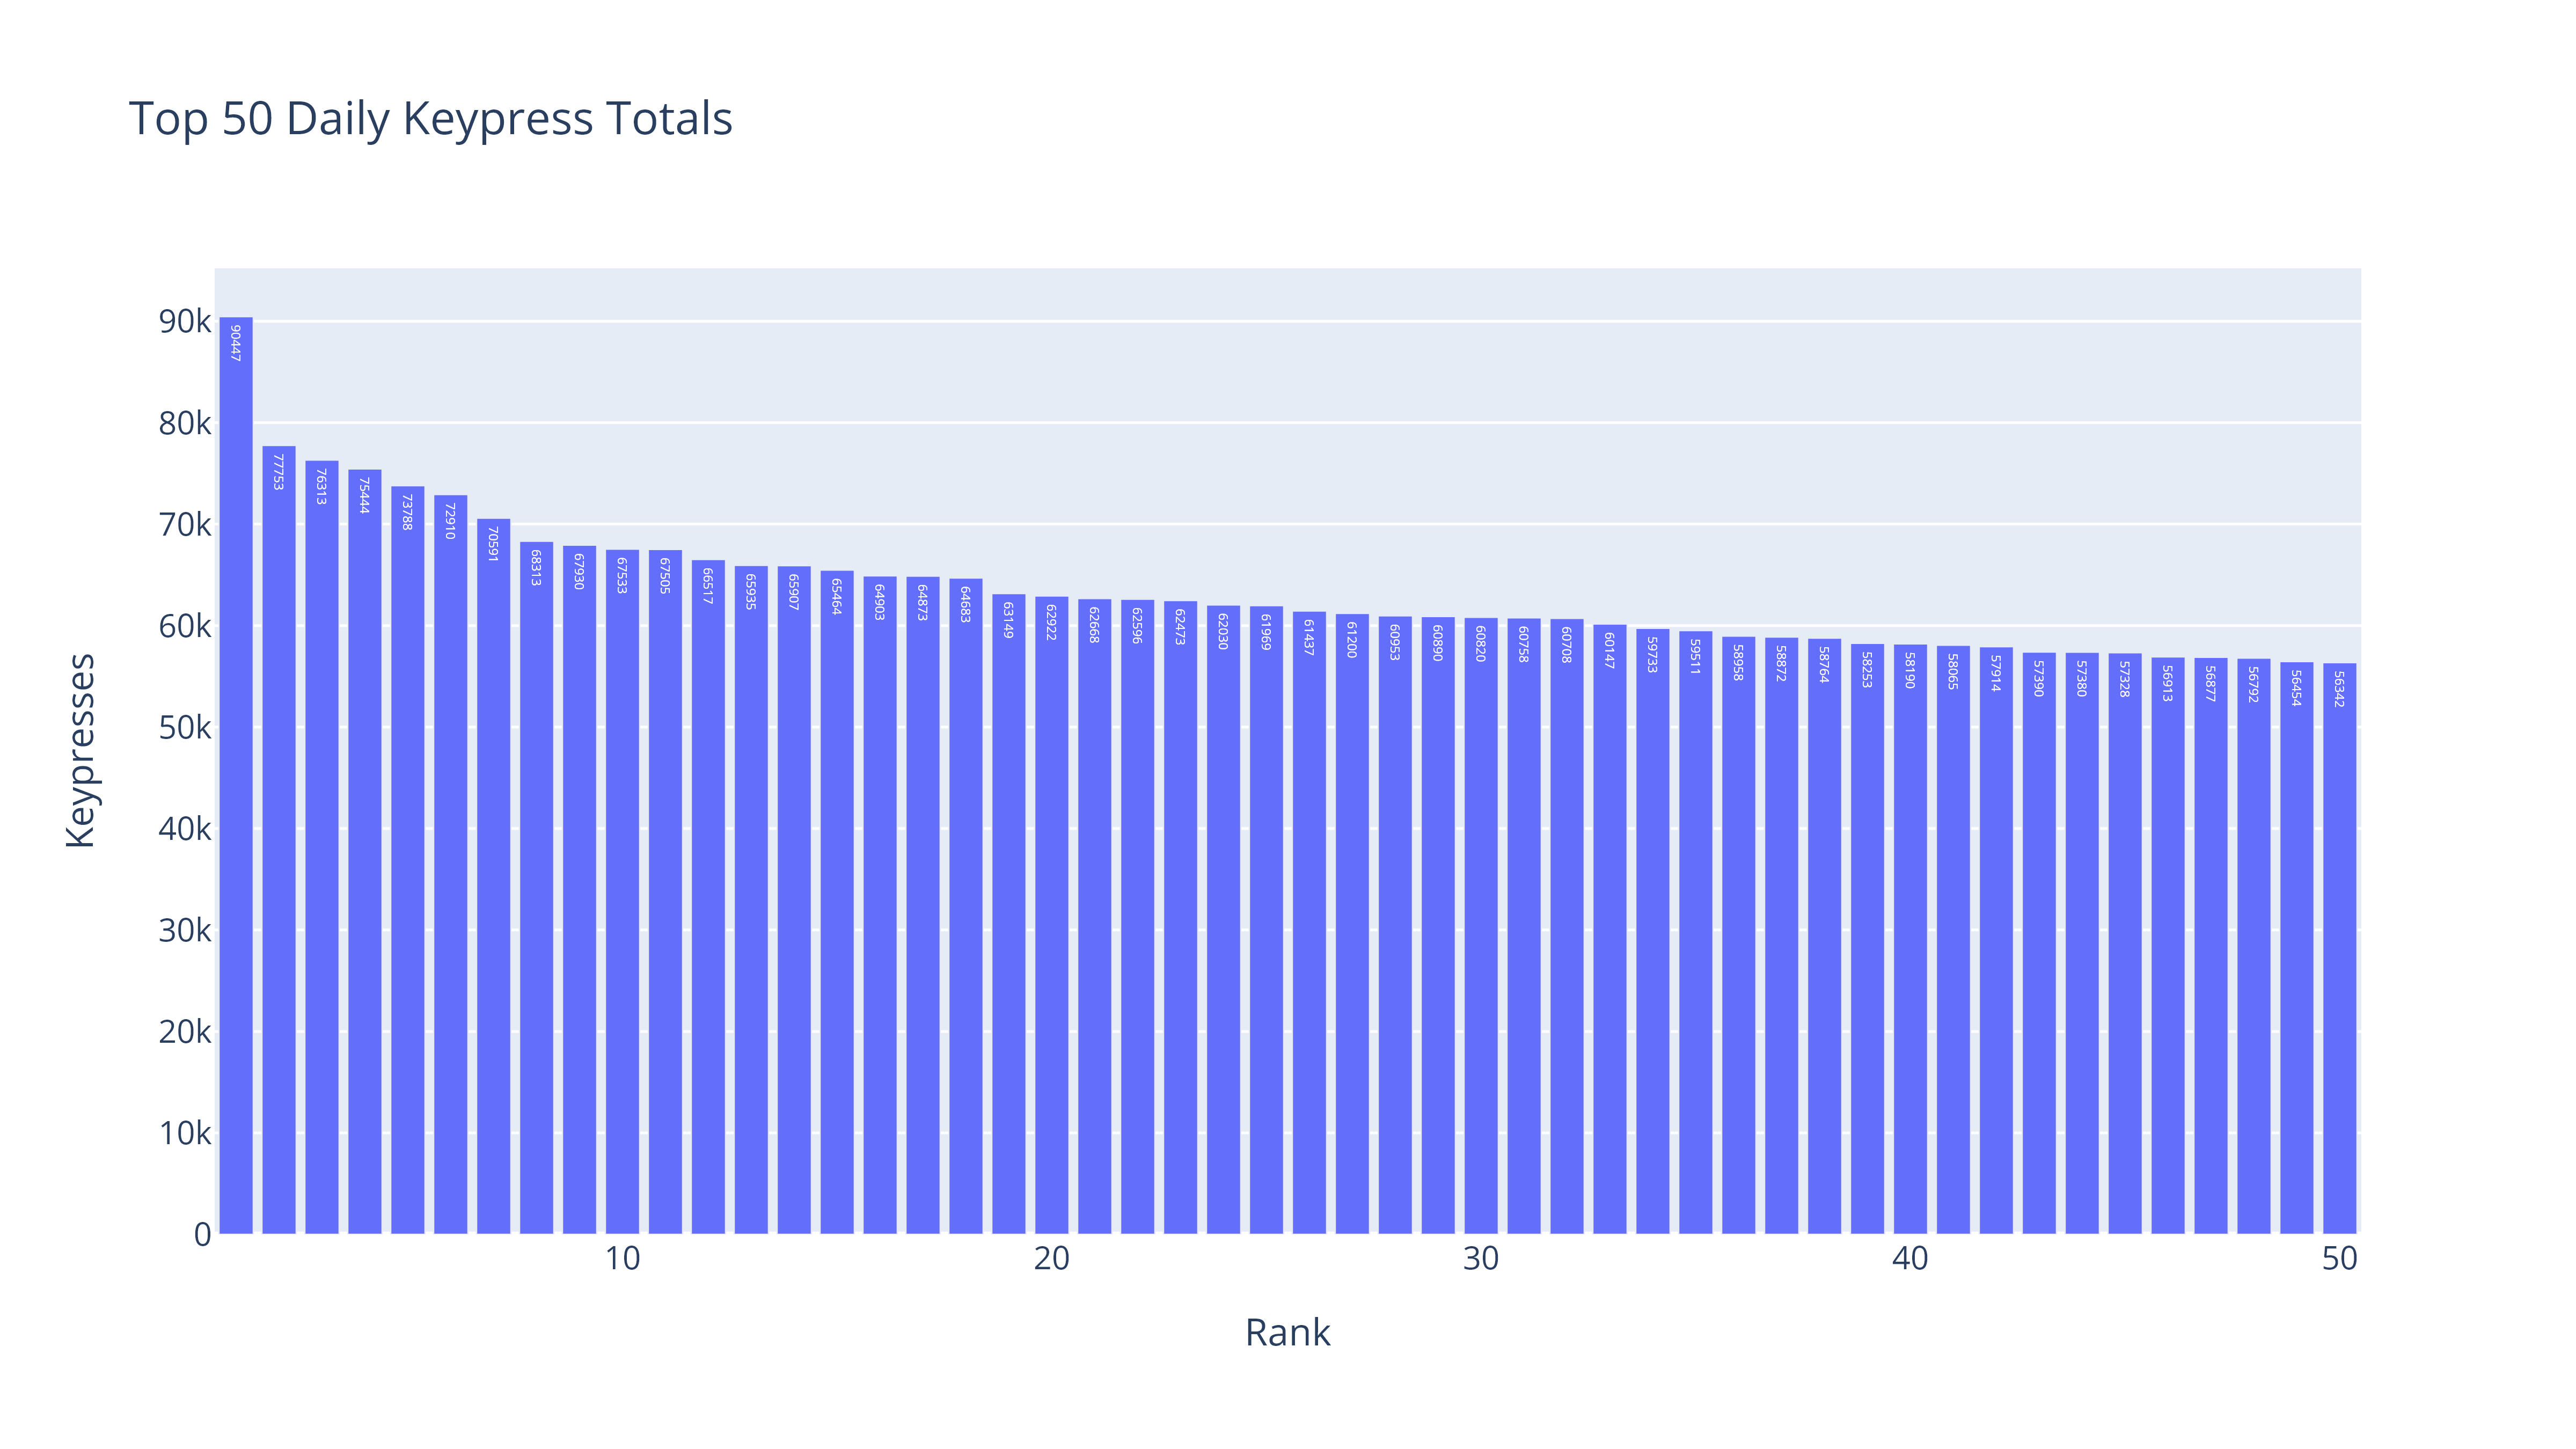

In [17]:
Image(static_graphs_folder+'top_50_keypresses.png')

## Keypress percentile data:

First, I'll calculate the keypress totals equal to the 90th through 100th percentiles (in 1-percentile increments).

In [18]:
df_combined_daily_keypresses['Keypresses'].describe(
    percentiles=np.linspace(0.9,1,11))[5:-1]
# The first four rows and final row provide additional descriptive statistics,
# so we can get rid of them
# by adding [4:-1] to the end of this line.
# There is probably a more elegant solution that retrieves only percentile
# data, but this option is fairly straightforward.

90%     48630.60
91%     49495.37
92%     50553.12
93%     52561.22
94%     54465.96
95%     56325.85
96%     58070.00
97%     60759.86
98%     62673.08
99%     67505.28
100%    90447.00
Name: Keypresses, dtype: float64

Scipy's percentileofscore() function can be used to calculate the percentile corresponding to a specific keypress total. For instance, here's the percentile for a day with only a single keypress: (The percentile may be higher than you'd expect due to the presence of many days with 0 keypresses)

In [19]:
percentileofscore(df_combined_daily_keypresses['Keypresses'], 1)

5.7

Next, I'll create a DataFrame showing the keypresses corresponding to every 5th percentile.

In [20]:
df_percentiles = df_combined_daily_keypresses['Keypresses'].describe(
percentiles=np.linspace(0,1,21))[4:-1].reset_index().sort_values(
    'Keypresses', ascending = False).reset_index(drop=True).rename(
        columns={'index':'percentile'})
# Calling reset_index() twice appears inefficient, but it makes it easier
# to sort by a particular value (in this case, keypresses).
keypress_difference_list = [df_percentiles.iloc[
    i, 1] - df_percentiles.iloc[i+1, 1] for i in range(len(df_percentiles) -1 )]
# This list comprehension calculates the difference between each row and 
# the row below it. This isn't possible for the final row,
# so we'll instead append a np.Nan to it.)
keypress_difference_list.append(np.NaN)
df_percentiles['difference_from_lower_percentile'] = keypress_difference_list
df_percentiles

percentile  Keypresses  difference_from_lower_percentile
0        100%    90447.00                          34121.15
1         95%    56325.85                           7695.25
2         90%    48630.60                           4560.00
3         85%    44070.60                           3955.20
4         80%    40115.40                           3256.15
5         75%    36859.25                           2436.55
6         70%    34422.70                           2805.85
7         65%    31616.85                           2821.05
8         60%    28795.80                           2252.40
9         55%    26543.40                           2181.40
10        50%    24362.00                           2931.20
11        45%    21430.80                           2429.80
12        40%    19001.00                           2576.45
13        35%    16424.55                           3477.55
14        30%    12947.00                           3620.50
15        25%     9326.50                           3125.90
16        20%     6200.60                           3438.65
17        15%     2761.95                           1920.55
18        10%      841.40                            841.40
19         5%        0.00                              0.00
20         0%        0.00                               NaN

The following chart shows the difference in keypresses between the different percentiles on this list.

In [21]:
px.bar(df_percentiles, x = 'percentile', 
       y = 'difference_from_lower_percentile')

And here's a histogram that shows the frequency of different keypress ranges:

In [22]:
fig_keypress_hist = px.histogram(df_combined_daily_keypresses, 
x = 'Keypresses', nbins = 40, text_auto = True, 
title = 'Histogram of Daily Keypress Totals')
# See https://plotly.com/python/histograms/
fig_keypress_hist.update_layout(bargap=0.1, yaxis_title = 'Days')
# https://plotly.com/python/histograms/
save_chart(fig_keypress_hist, 'daily_keypress_histogram')
fig_keypress_hist

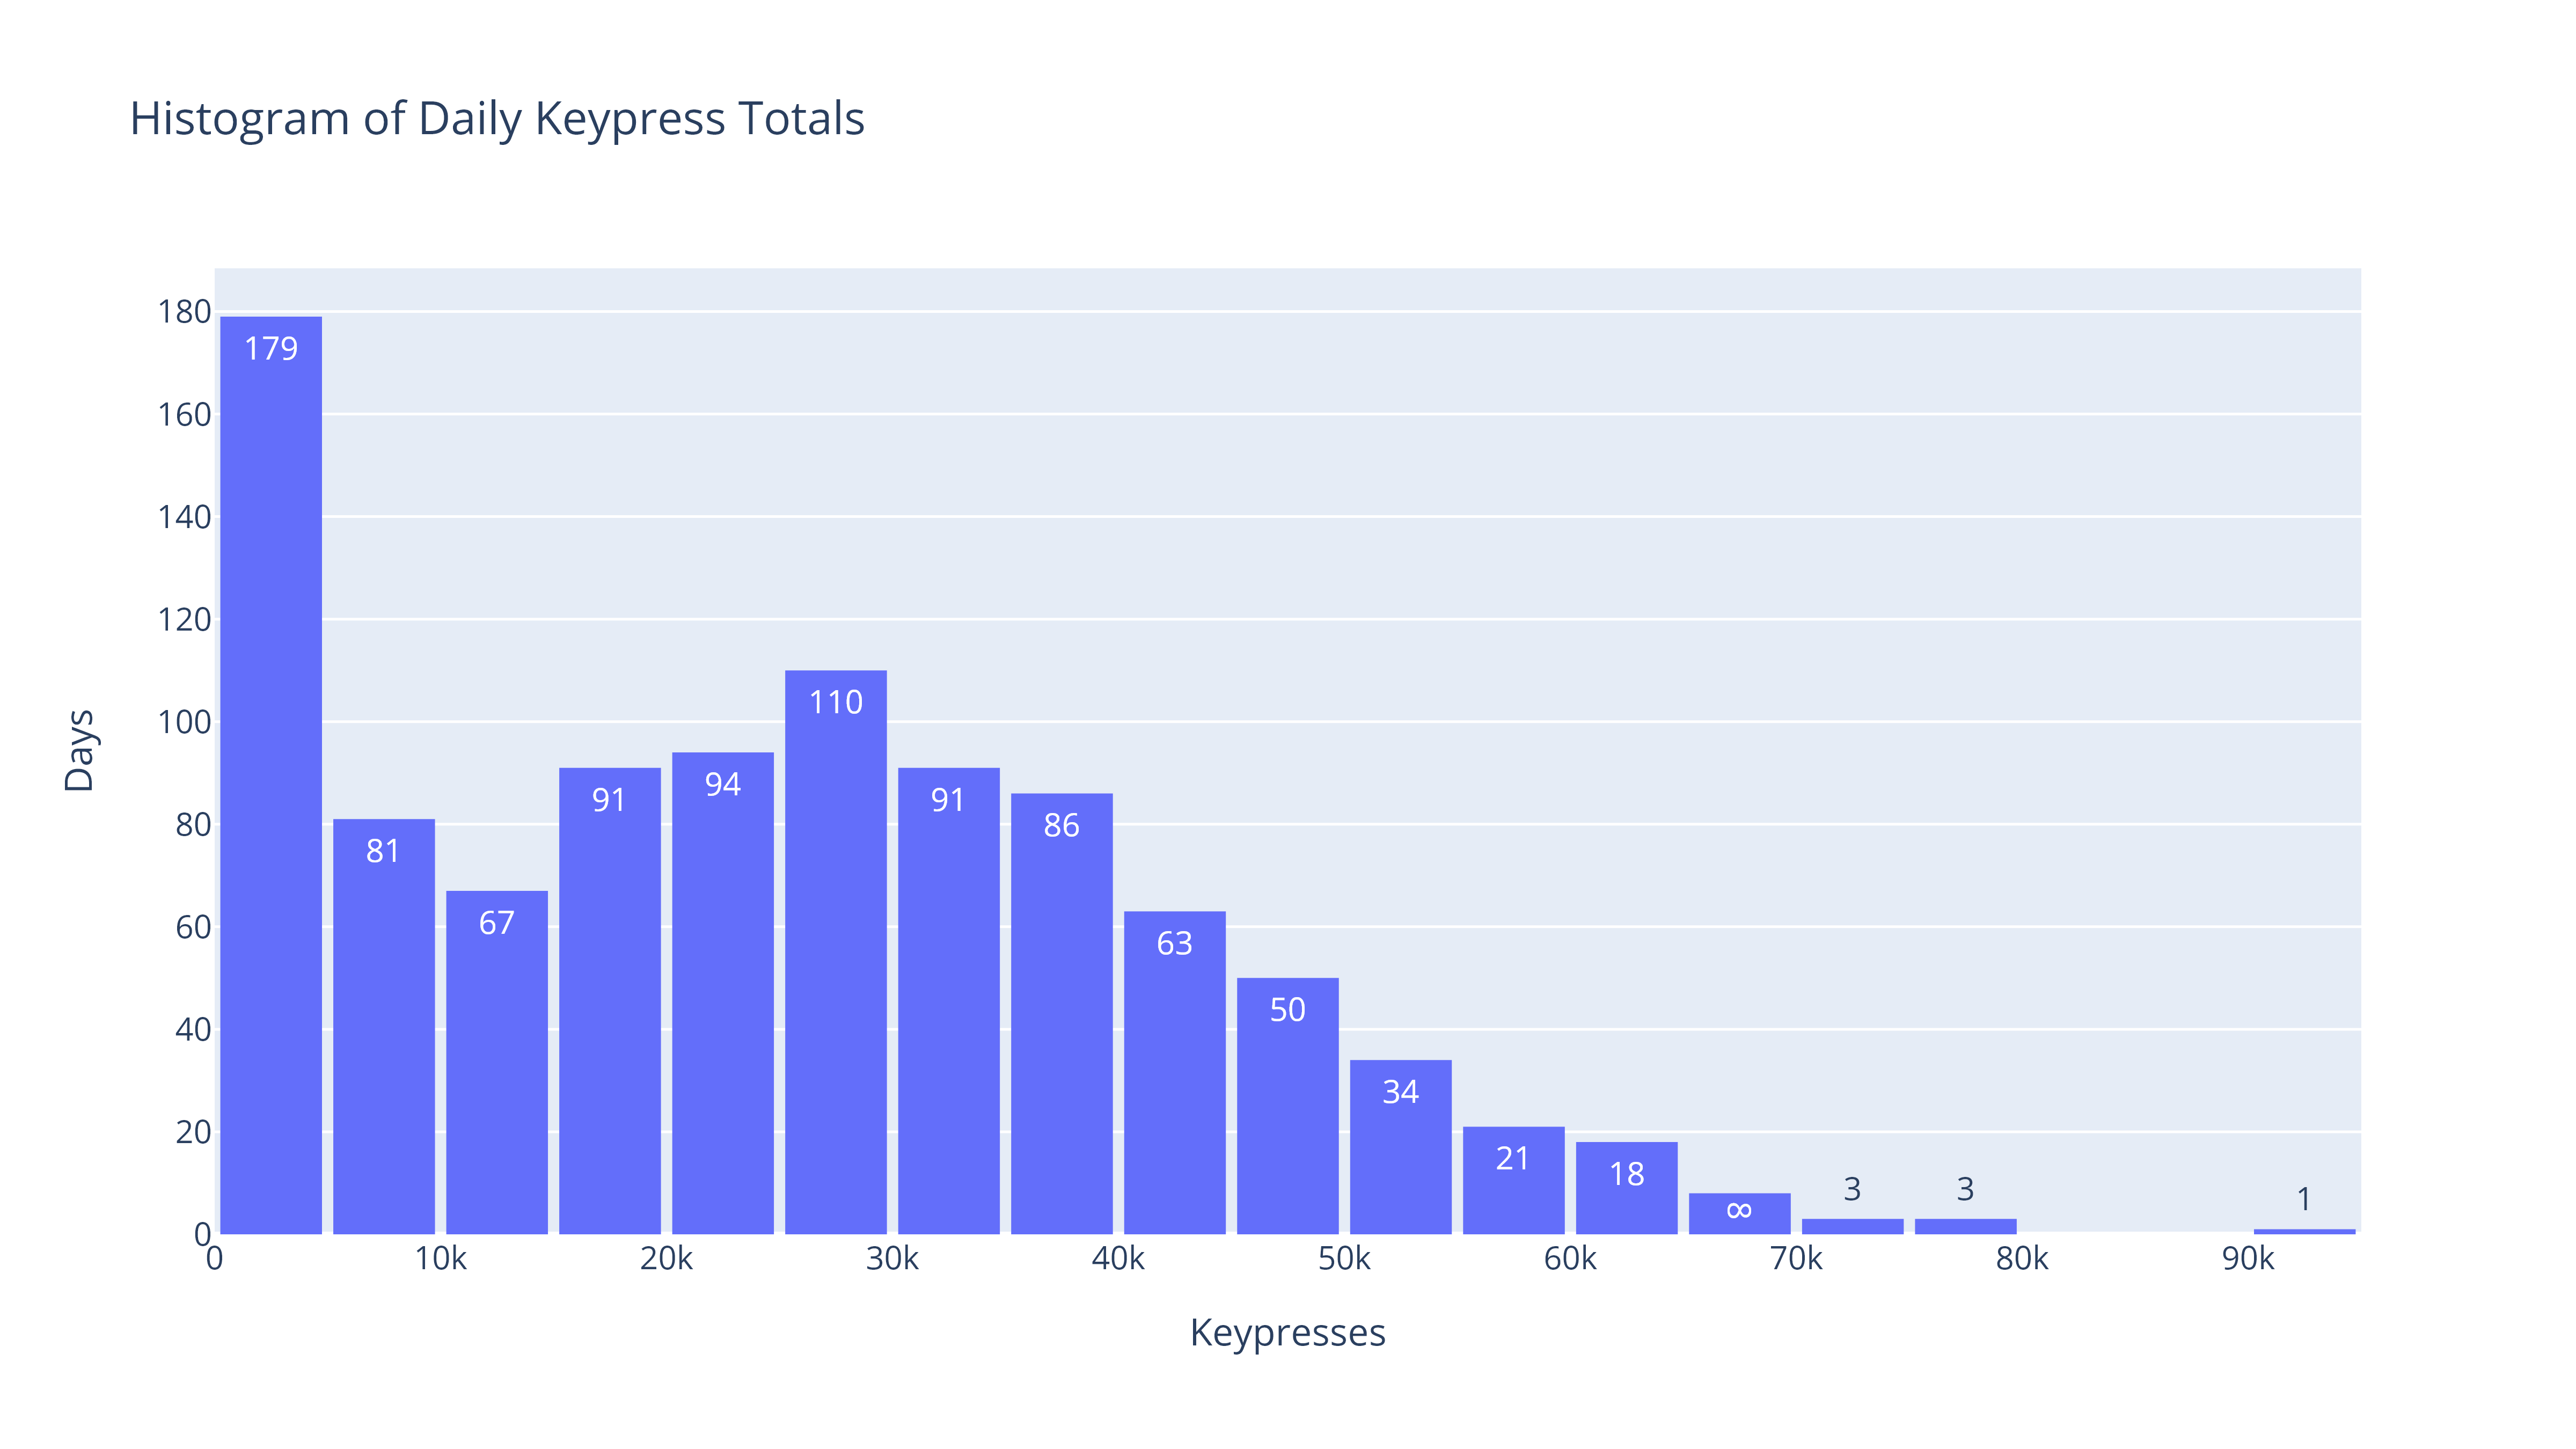

In [23]:
Image(static_graphs_folder+'daily_keypress_histogram.png')

I'll now create a pivot table that shows my average keypresses per weekday:

In [24]:
df_weekday_pivot = df_combined_daily_keypresses.pivot_table(
    index = 'Weekday', values = 'Keypresses', aggfunc = 'mean').sort_values(
    'Weekday', ascending = False).reset_index()
# Adding in a Weekday_Order column so that 
# weekdays can be sorted chronologically:
df_weekday_pivot['Weekday_Order'] = df_weekday_pivot['Weekday'].map(
{'Sunday':0,'Monday':1,"Tuesday":2,"Wednesday":3,
"Thursday":4,"Friday":5,"Saturday":6})
df_weekday_pivot

Weekday    Keypresses  Weekday_Order
0  Wednesday  30126.776224              3
1    Tuesday  32195.909091              2
2   Thursday  30975.510490              4
3     Sunday  11266.450704              0
4   Saturday  13840.524476              6
5     Monday  31287.454545              1
6     Friday  23725.202797              5

In [25]:
df_weekday_pivot.sort_values('Weekday_Order', inplace = True)
df_weekday_pivot

Weekday    Keypresses  Weekday_Order
3     Sunday  11266.450704              0
5     Monday  31287.454545              1
1    Tuesday  32195.909091              2
0  Wednesday  30126.776224              3
2   Thursday  30975.510490              4
6     Friday  23725.202797              5
4   Saturday  13840.524476              6

Graphing my average keypresses per weekday:

In [26]:
fig_keypresses_by_weekday = px.bar(df_weekday_pivot, x = 'Weekday', 
y = 'Keypresses', text_auto = '.0f', color = 'Keypresses', 
color_continuous_scale = 'PrGn')
# For text_auto, see: 
# https://plotly.com/python-api-reference/generated/plotly.express.bar

# For color scale options and usage, 
# visit https://plotly.com/python/builtin-colorscales/
fig_keypresses_by_weekday.update_traces(marker_line_color='rgb(0,0,0)', 
                                        marker_line_width=0.5, opacity=1)
fig_keypresses_by_weekday

save_chart(fig_keypresses_by_weekday, file_name = 'keypresses_by_weekday')

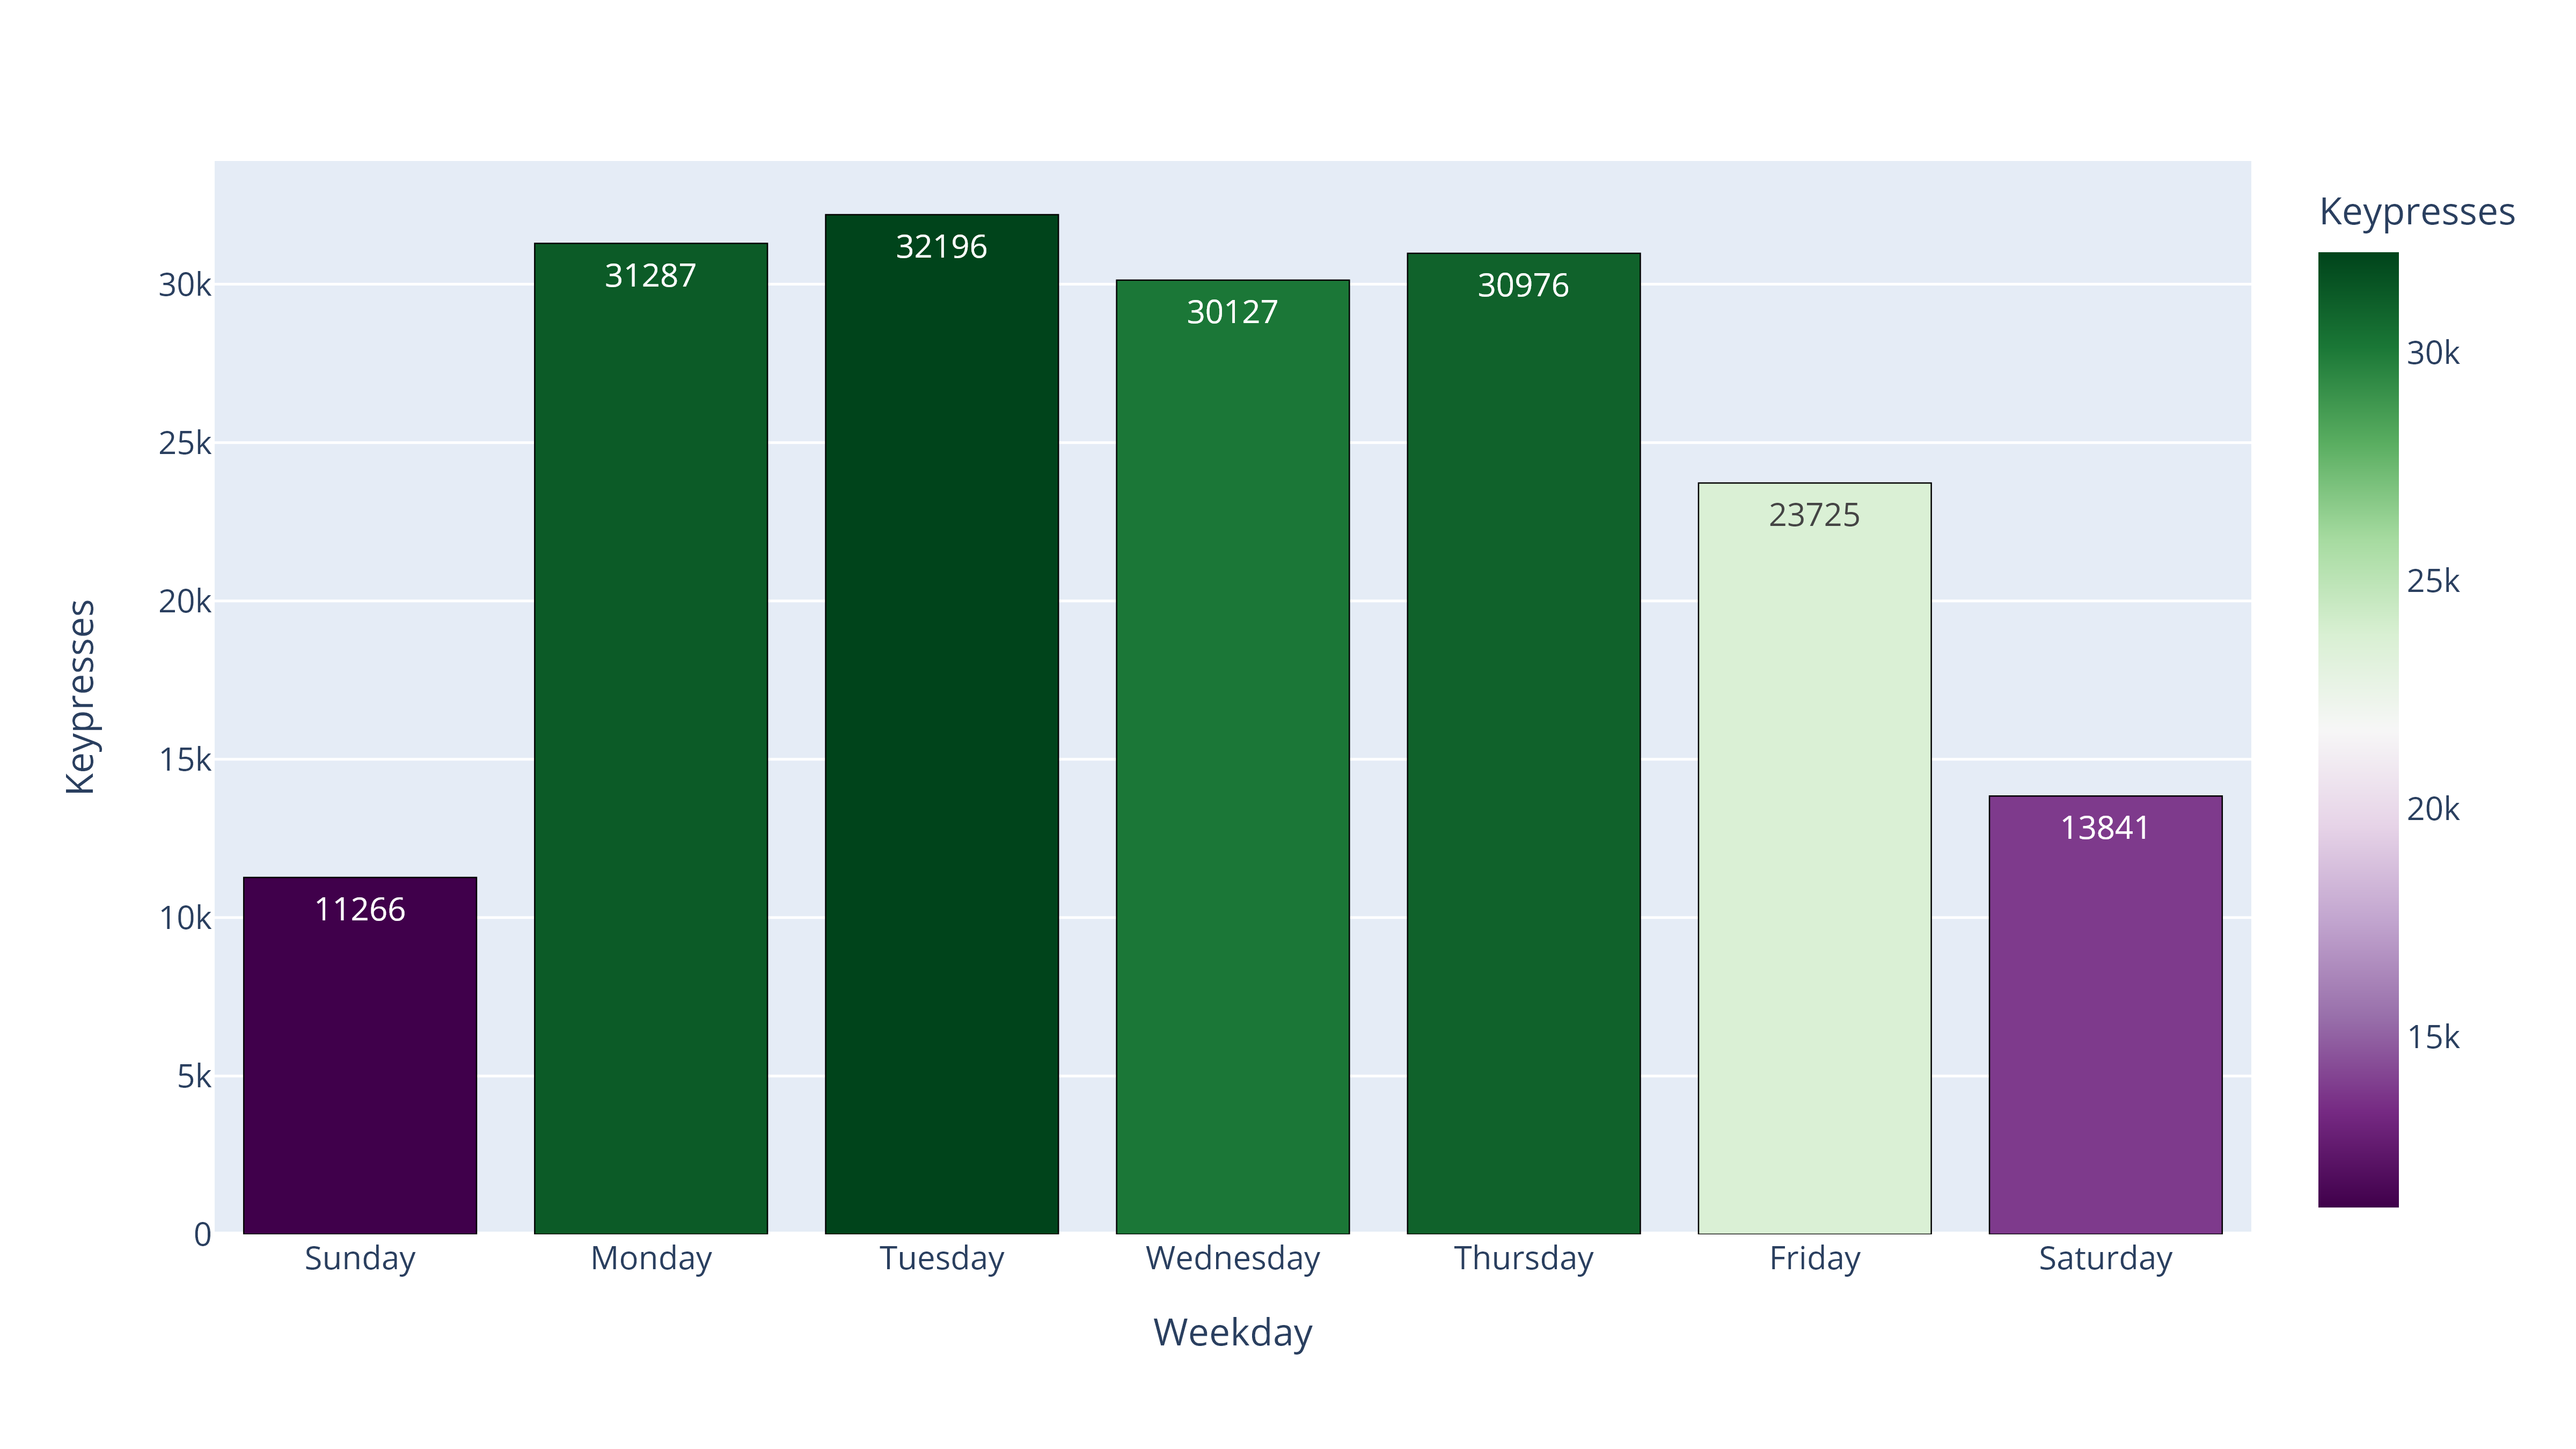

In [27]:
Image(static_graphs_folder+'keypresses_by_weekday.png')

### Total keypresses since first date in DataFrame:

In [28]:
print("Total keypresess since", str(
df_combined_daily_keypresses.iloc[0]['Date'])+":",'{:,}'.format(
sum(df_combined_daily_keypresses['Keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 24,787,483


### Keypresses over the past 50 days:

In [29]:
df_combined_daily_keypresses.tail(50) # Last 50 days

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
950 2023-04-29          86    984.571429  10928.107143  20472.975342   
951 2023-04-30         728   1004.714286  10709.571429  20429.076712   
952 2023-05-01       19015   3704.428571  10657.785714  20459.320548   
953 2023-05-02       34457   8225.714286  10572.857143  20446.194521   
954 2023-05-03       18004  10750.142857  10278.821429  20295.767123   
955 2023-05-04       37630  16069.000000  10907.857143  20328.997260   
956 2023-05-05       18761  18383.000000  11071.035714  20359.627397   
957 2023-05-06         169  18394.857143  10309.500000  20360.090411   
958 2023-05-07         560  18370.857143   9619.500000  20359.041096   
959 2023-05-08       19163  18392.000000   8272.571429  20411.542466   
960 2023-05-09        8680  14709.571429   7695.642857  20380.824658   
961 2023-05-10       11651  13802.000000   7024.892857  20339.323288   
962 2023-05-11       21576  11508.571429   7114.928571  20352.210959   
963 2023-05-12       22426  12032.142857   7915.857143  20365.186301   
964 2023-05-13        8567  13231.857143   8221.464286  20261.473973   
965 2023-05-14           0  13151.857143   8221.464286  20147.783562   
966 2023-05-15       21071  13424.428571   8974.000000  20185.317808   
967 2023-05-16       33128  16917.000000  10157.142857  20180.243836   
968 2023-05-17       36202  20424.285714  11450.071429  20253.912329   
969 2023-05-18       31715  21872.714286  12581.642857  20339.254795   
970 2023-05-19       32481  23309.142857  13741.678571  20426.805479   
971 2023-05-20       17741  24619.714286  14307.750000  20471.232877   
972 2023-05-21        9439  25968.142857  14623.892857  20486.112329   
973 2023-05-22       28640  27049.428571  15642.571429  20541.139726   
974 2023-05-23       34138  27193.714286  16761.500000  20579.046575   
975 2023-05-24       16854  24429.714286  17351.535714  20552.175342   
976 2023-05-25       41420  25816.142857  18816.607143  20591.695890   
977 2023-05-26       25947  24882.714286  19651.750000  20492.838356   
978 2023-05-27       16401  24691.285714  20234.428571  20441.893151   
979 2023-05-28           0  23342.857143  20208.428571  20404.309589   
980 2023-05-29        1259  19431.285714  19574.285714  20382.767123   
981 2023-05-30       33991  19410.285714  19557.642857  20411.580822   
982 2023-05-31       64683  26243.000000  21224.750000  20534.572603   
983 2023-06-01       29651  24561.714286  20939.785714  20580.375342   
984 2023-06-02       35650  25947.857143  21542.964286  20603.668493   
985 2023-06-03        7364  24656.857143  21799.928571  20558.572603   
986 2023-06-04       29370  28852.571429  22828.857143  20622.049315   
987 2023-06-05       26859  32509.714286  23103.714286  20653.106849   
988 2023-06-06       28010  31655.285714  23794.071429  20690.975342   
989 2023-06-07       29368  26610.285714  24426.821429  20656.701370   
990 2023-06-08       26378  26142.714286  24598.321429  20701.928767   
991 2023-06-09        1999  21335.428571  23868.785714  20635.723288   
992 2023-06-10           0  20283.428571  23562.821429  20623.246575   
993 2023-06-11       14647  18180.142857  24085.928571  20663.087671   
994 2023-06-12       31281  18811.857143  24450.571429  20748.789041   
995 2023-06-13       23745  18202.571429  24115.464286  20799.172603   
996 2023-06-14       50339  21198.428571  24620.357143  20934.254795   
997 2023-06-15       45835  23978.000000  25124.642857  21042.520548   
998 2023-06-16       40815  29523.142857  25422.285714  21048.158904   
999 2023-06-17       11847  31215.571429  25211.785714  21031.334247   

     percentile   rank    Weekday  
950        6.60  935.0   Saturday  
951        9.70  904.0     Sunday  
952       40.10  600.0     Monday  
953       70.10  300.0    Tuesday  
954       37.70  624.0  Wednesday  
955       76.00  241.0   Thursday  
956       39.40  607.0     Friday  
957        7.40  927.0   Saturday  
958        9.

The following cell outputs various keypress statistics. When this script is run hourly, these statistics (along with other ones) will then appear in the console terminal.

In [30]:
days_with_data = len(df_combined_daily_keypresses)
#  The following column cell shows the ranks immediately above the ranks for the most recent day.
keypresses_today = df_combined_daily_keypresses.iloc[-1]['Keypresses']
percentile_today = df_combined_daily_keypresses.iloc[-1]['percentile']
rank_today = df_combined_daily_keypresses.iloc[-1]['rank']
print("Ranks are out of", days_with_data, "days.")
print(f"Today's keypresses: {keypresses_today}")
print(f"Your keypress totals yesterday and 7, 28, and 365 days ago were \
{df_combined_daily_keypresses.iloc[-2]['Keypresses']}, \
{df_combined_daily_keypresses.iloc[-8]['Keypresses']}, \
{df_combined_daily_keypresses.iloc[-29]['Keypresses']}, \
and {df_combined_daily_keypresses.iloc[-366]['Keypresses']}, respectively.")
# If your keypresses today are higher than these values, the moving averages
# associated with those values will increase.
print(f"Today's percentile: {round(percentile_today, 3)}")
print(f"Today's rank: {rank_today} \
(in front of {days_with_data - rank_today} days)")

Ranks are out of 1000 days.
Today's keypresses: 11847
Your keypress totals yesterday and 7, 28, and 365 days ago were 40815, 0, 17741, and 17988, respectively.
Today's percentile: 28.1
Today's rank: 720.0 (in front of 280.0 days)


Days ranked just ahead of today (along with today's rank):

In [31]:
df_days_with_higher_keypresses = df_combined_daily_keypresses.sort_values(
    'rank').query("rank <= @rank_today").tail(11)
keypress_difference_list = [df_days_with_higher_keypresses.iloc[i][
    'Keypresses'] - df_days_with_higher_keypresses.iloc[i+1][
        'Keypresses'] for i in range(len(df_days_with_higher_keypresses) -1 )]
keypress_difference_list.append(np.NaN)
df_days_with_higher_keypresses[
    'diff_from_following_day'] = keypress_difference_list
df_days_with_higher_keypresses[
    'diff_from_current_day'] = df_days_with_higher_keypresses[
        'Keypresses'] - df_days_with_higher_keypresses.iloc[-1]['Keypresses']
df_days_with_higher_keypresses

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
450 2021-12-15       12534  24393.285714  24176.857143  28481.249315   
511 2022-02-14       12485  14014.857143  23311.857143  26597.468493   
339 2021-08-26       12438  20241.000000  25196.464286           NaN   
218 2021-04-27       12366  20405.285714  31063.964286           NaN   
725 2022-09-16       12358  12115.857143  16252.000000  22148.317808   
865 2023-02-03       12352  19716.285714  20504.464286  20626.627397   
732 2022-09-23       12256   7276.714286  10237.928571  21637.904110   
217 2021-04-26       12249  26418.571429  32755.642857           NaN   
756 2022-10-17       12127  20903.857143  17160.535714  20563.545205   
137 2021-02-05       11856  35910.142857  35065.821429           NaN   
999 2023-06-17       11847  31215.571429  25211.785714  21031.334247   

     percentile   rank    Weekday  diff_from_following_day  \
450        29.1  710.0  Wednesday                     49.0   
511        29.0  711.0     Monday                     47.0   
339        28.9  712.0   Thursday                     72.0   
218        28.8  713.0    Tuesday                      8.0   
725        28.7  714.0     Friday                      6.0   
865        28.6  715.0     Friday                     96.0   
732        28.5  716.0     Friday                      7.0   
217        28.4  717.0     Monday                    122.0   
756        28.3  718.0     Monday                    271.0   
137        28.2  719.0     Friday                      9.0   
999        28.1  720.0   Saturday                      NaN   

     diff_from_current_day  
450                    687  
511                    638  
339                    591  
218                    519  
725                    511  
865                    505  
732                    409  
217                    402  
756                    280  
137                      9  
999                      0

Looking for days with identical non-zero keypress totals:

In [32]:
duplicated_keypress_dates = df_combined_daily_keypresses[
df_combined_daily_keypresses.duplicated(
subset = 'Keypresses', keep = False)].query('Keypresses > 0').sort_values(
'Keypresses', ascending = False)
len(duplicated_keypress_dates)

16

In [33]:
duplicated_keypress_dates

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
32  2020-10-23       48908  41125.571429  37996.178571           NaN   
183 2021-03-23       48908  36708.000000  32516.464286           NaN   
3   2020-09-24       34698           NaN           NaN           NaN   
124 2021-01-23       34698  34726.428571  24214.178571           NaN   
318 2021-08-05       32184  29066.857143  29787.500000           NaN   
676 2022-07-29       32184  26384.571429  26299.000000  23180.561644   
687 2022-08-09       26905  21784.571429  25372.785714  22972.580822   
765 2022-10-26       26905  25745.714286  20627.357143  20359.476712   
55  2020-11-15       26550  36325.285714  35269.428571           NaN   
645 2022-06-28       26550  12407.857143  12670.821429  23373.895890   
662 2022-07-15       25084  28583.714286  18304.428571  23319.049315   
841 2023-01-10       25084  16131.571429  16824.607143  21120.632877   
321 2021-08-08        6318  30379.714286  30359.035714           NaN   
632 2022-06-15        6318   6218.571429  15957.071429  23702.145205   
536 2022-03-11         149  10365.285714  15863.214286  25284.586301   
538 2022-03-13         149   8908.285714  15542.392857  25160.463014   

     percentile   rank    Weekday  
32        90.35   97.5     Friday  
183       90.35   97.5    Tuesday  
3         70.55  295.5   Thursday  
124       70.55  295.5   Saturday  
318       66.35  337.5   Thursday  
676       66.35  337.5     Friday  
687       56.25  438.5    Tuesday  
765       56.25  438.5  Wednesday  
55        55.15  449.5     Sunday  
645       55.15  449.5    Tuesday  
662       51.45  486.5     Friday  
841       51.45  486.5    Tuesday  
321       20.35  797.5     Sunday  
632       20.35  797.5  Wednesday  
536        7.05  930.5     Friday  
538        7.05  930.5     Sunday

In [34]:
df_combined_daily_keypresses

Date  Keypresses      7_day_ma     28_day_ma    365_day_ma  \
0   2020-09-21       19081           NaN           NaN           NaN   
1   2020-09-22       32771           NaN           NaN           NaN   
2   2020-09-23       32065           NaN           NaN           NaN   
3   2020-09-24       34698           NaN           NaN           NaN   
4   2020-09-25       47038           NaN           NaN           NaN   
..         ...         ...           ...           ...           ...   
995 2023-06-13       23745  18202.571429  24115.464286  20799.172603   
996 2023-06-14       50339  21198.428571  24620.357143  20934.254795   
997 2023-06-15       45835  23978.000000  25124.642857  21042.520548   
998 2023-06-16       40815  29523.142857  25422.285714  21048.158904   
999 2023-06-17       11847  31215.571429  25211.785714  21031.334247   

     percentile   rank    Weekday  
0         40.30  598.0     Monday  
1         67.50  326.0    Tuesday  
2         65.90  342.0  Wednesday  
3         70.55  295.5   Thursday  
4         88.50  116.0     Friday  
..          ...    ...        ...  
995       48.90  512.0    Tuesday  
996       91.80   83.0  Wednesday  
997       87.40  127.0   Thursday  
998       80.70  194.0     Friday  
999       28.10  720.0   Saturday  

[1000 rows x 8 columns]

In [35]:
df_combined_daily_keypresses['Date']

0     2020-09-21
1     2020-09-22
2     2020-09-23
3     2020-09-24
4     2020-09-25
         ...    
995   2023-06-13
996   2023-06-14
997   2023-06-15
998   2023-06-16
999   2023-06-17
Name: Date, Length: 1000, dtype: datetime64[ns]

## Plotting Chronological Keypress Data

Now that we have a DataFrame showing daily keypresses and multiple moving averages, it's time to visualize it! The advantage of creating this chart within Plotly is that, being HTML-based, it is interactive in nature. Thus, you can hover over the lines to view the values corresponding to those lines and zoom in to get a closer look at a particular section of the graph. As before, though, this graph can also be saved as a static image.

In [36]:
fig_keypresses_line_chart = px.line(df_combined_daily_keypresses, x = 'Date', 
y = ['Keypresses', '7_day_ma', '28_day_ma', '365_day_ma']) 
# Note that multiple y values can be passed to the line chart. 

save_chart(fig_keypresses_line_chart, 'px_daily_keypresses_and_mas')

fig_keypresses_line_chart

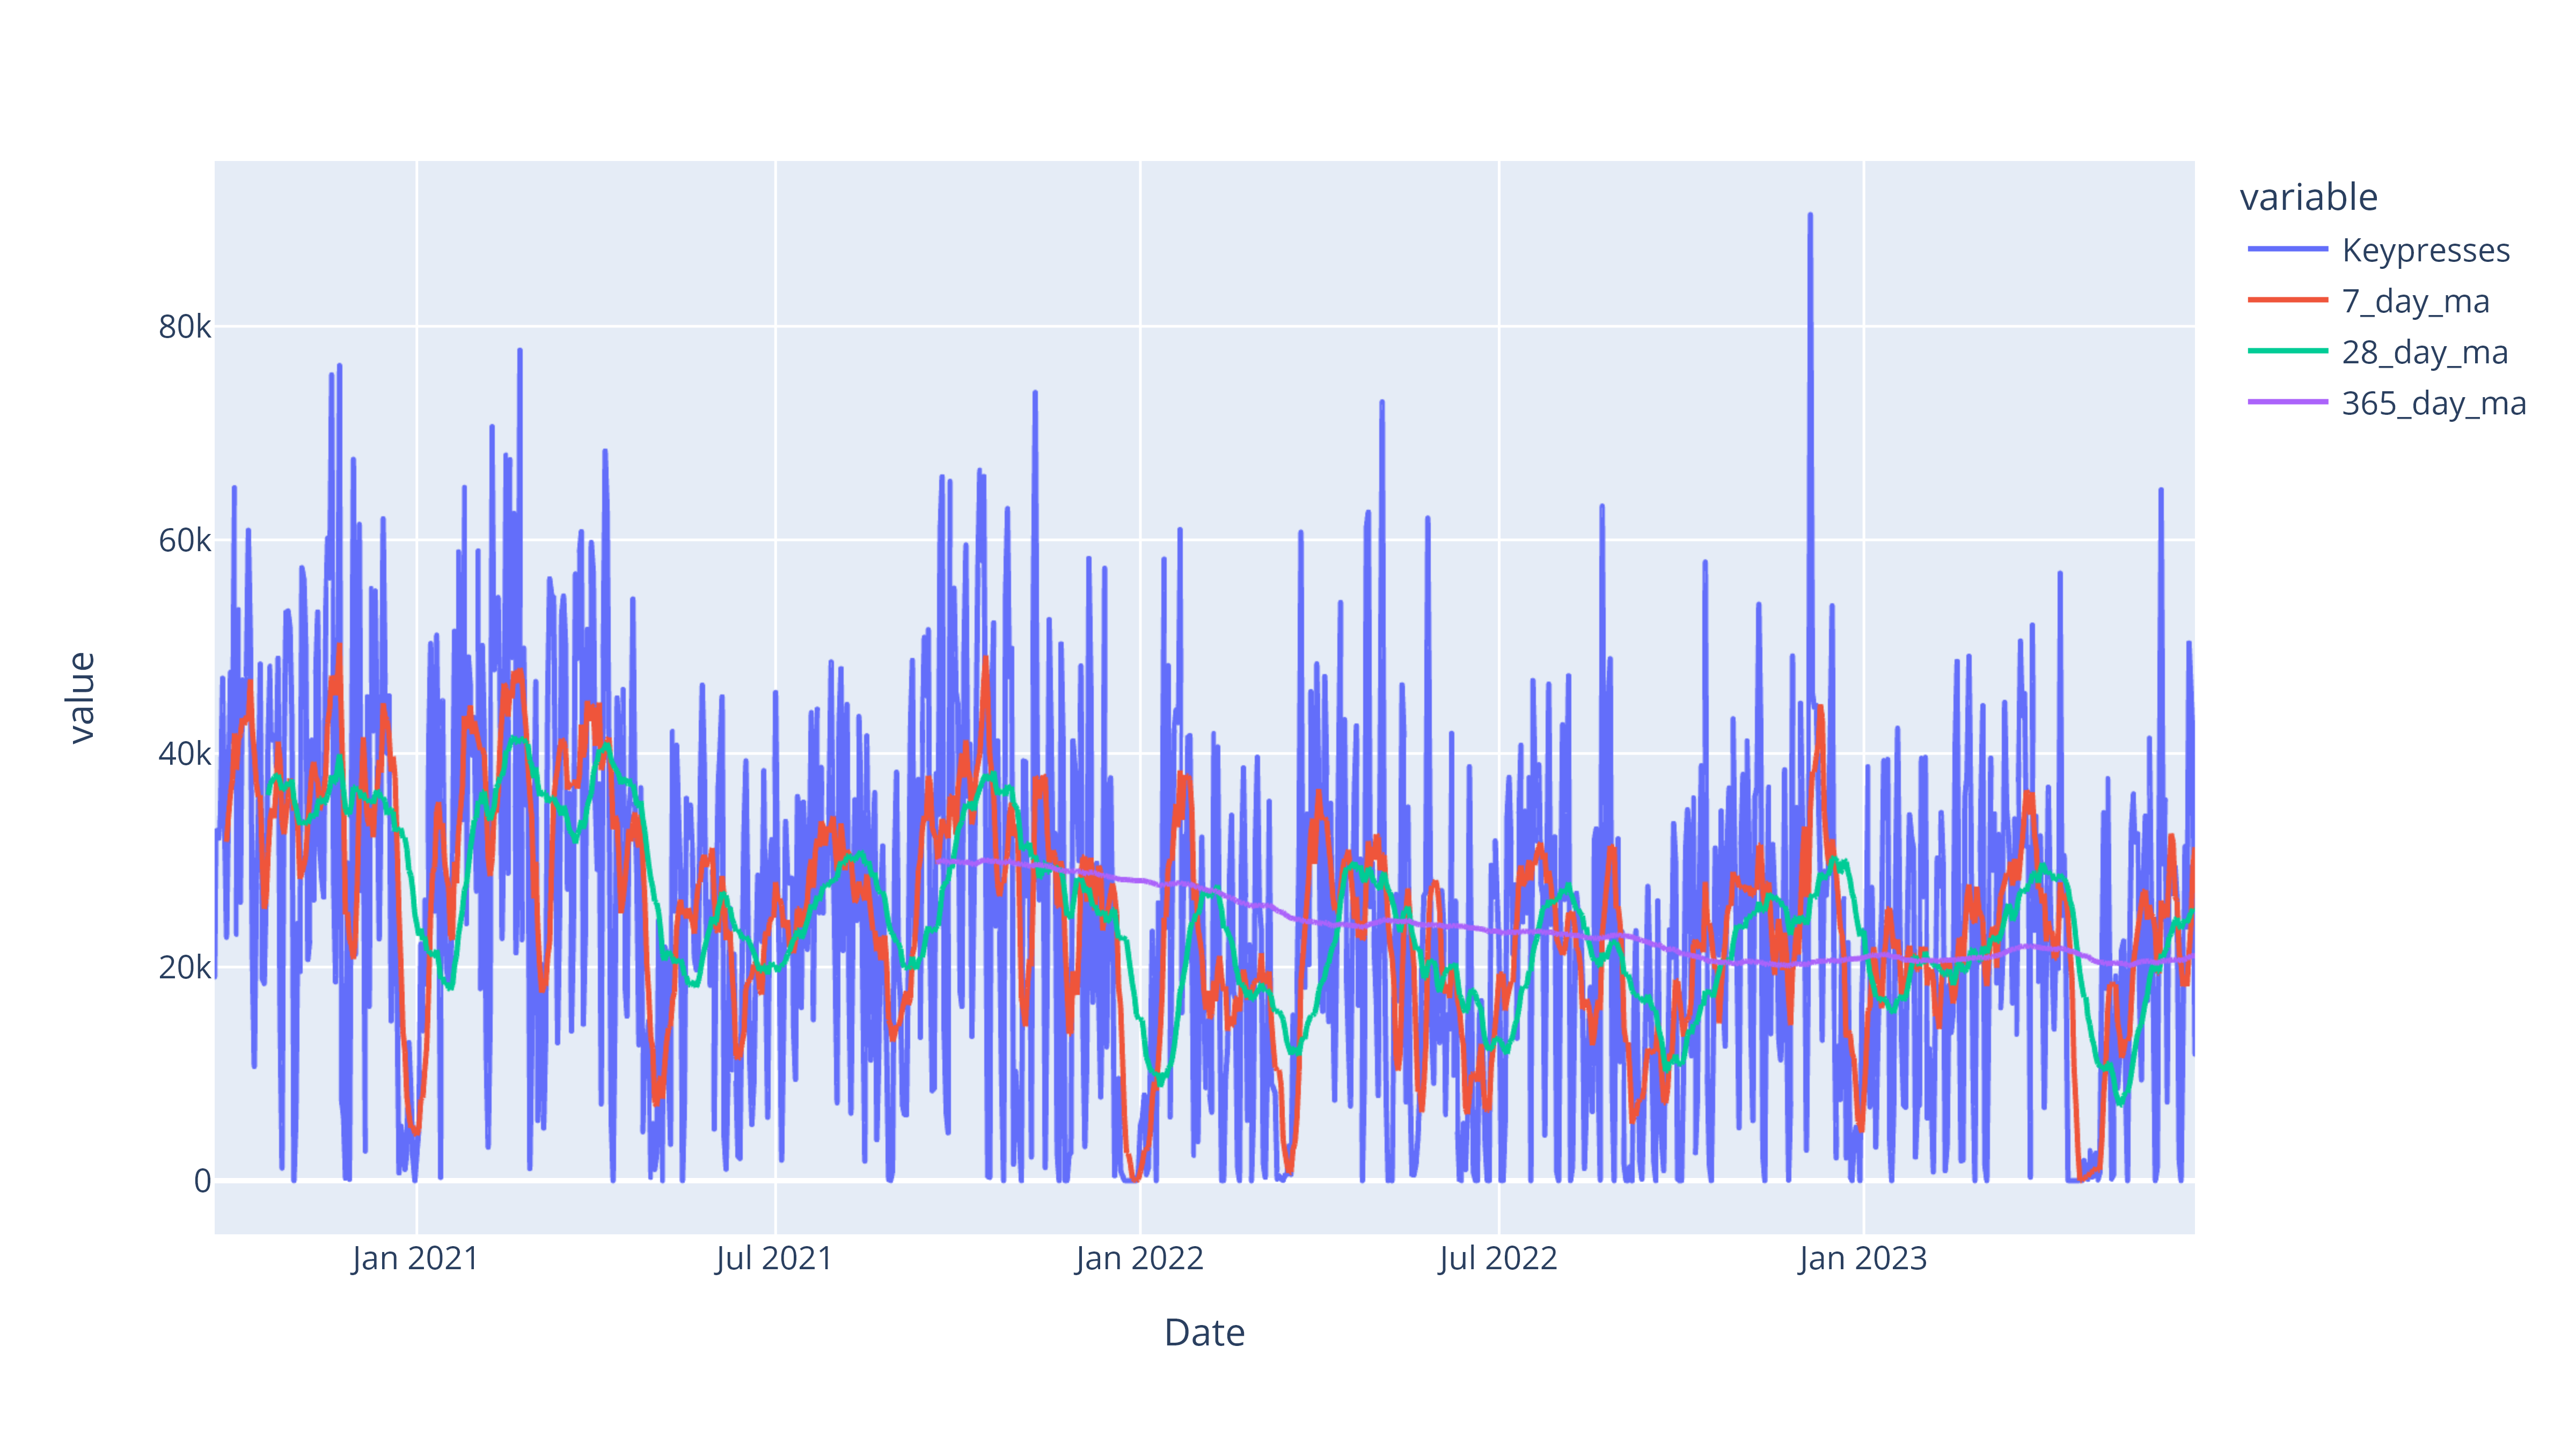

In [37]:
Image(static_graphs_folder+'px_daily_keypresses_and_mas.png')

## Monthly keypress totals:

In [38]:
df_monthly_keypresses = df_combined_daily_keypresses.copy().set_index(
    'Date').resample('M').sum()['Keypresses'].reset_index()
df_monthly_keypresses['Month'] = df_monthly_keypresses['Date'].dt.to_period('M')
df_monthly_keypresses['Year'] = df_monthly_keypresses['Date'].dt.to_period('Y')
df_monthly_keypresses.drop('Date', axis = 1, inplace = True)
df_monthly_keypresses['Keypresses'] = df_monthly_keypresses.pop('Keypresses')
df_monthly_keypresses

Month  Year  Keypresses
0   2020-09  2020      346918
1   2020-10  2020     1140421
2   2020-11  2020     1061614
3   2020-12  2020      823763
4   2021-01  2021      980116
5   2021-02  2021     1088404
6   2021-03  2021     1142850
7   2021-04  2021      833464
8   2021-05  2021      700155
9   2021-06  2021      621894
10  2021-07  2021      881137
11  2021-08  2021      722970
12  2021-09  2021      919571
13  2021-10  2021     1051663
14  2021-11  2021      797115
15  2021-12  2021      515936
16  2022-01  2022      729233
17  2022-02  2022      487910
18  2022-03  2022      552559
19  2022-04  2022      834250
20  2022-05  2022      627263
21  2022-06  2022      412725
22  2022-07  2022      758759
23  2022-08  2022      691636
24  2022-09  2022      330566
25  2022-10  2022      706081
26  2022-11  2022      756509
27  2022-12  2022      720251
28  2023-01  2023      652155
29  2023-02  2023      580208
30  2023-03  2023      892786
31  2023-04  2023      327674
32  2023-05  2023      665769
33  2023-06  2023      433158

# Saving the updated version of this DataFrame to a .csv file:

In [39]:
df_combined_daily_keypresses.to_csv(
    'data/df_combined_daily_keypresses_updated.csv')

## Hourly keypress stats:

In order to calculate hourly keypress statistics, we'll need to create a new DataFrame that aggregates keypresses by hour instead of by day.

In [40]:
hourly_keypress_db_list = []

for db_path in database_paths_list:
    hourly_keypress_db_list.append(generate_keypress_totals(
        database_path = db_path, level = 'hourly'))

df_hourly_keypresses = pd.concat([
    df for df in hourly_keypress_db_list]).reset_index(drop=True)

# As with my daily keypresess DataFrame, I'll use pivot_table() to group 
# multiple rows for the same day and hour into a single row. (These multiple 
# rows are the result of my using multiple computers during the same hour.)
df_hourly_keypresses = df_hourly_keypresses.pivot_table(index = [
    'Day', 'Hour'], values = 'Keypresses', aggfunc = 'sum').reset_index().sort_values(['Day', 'Hour'])

df_hourly_keypresses.to_csv(
    'data/df_combined_hourly_keypresses.csv', index = False)
df_hourly_keypresses

Day  Hour  Keypresses
0      2020-09-21    15         278
1      2020-09-21    16         567
2      2020-09-21    17        1218
3      2020-09-21    18        3300
4      2020-09-21    19        3888
...           ...   ...         ...
11394  2023-06-17    12          26
11395  2023-06-17    13           0
11396  2023-06-17    14        4274
11397  2023-06-17    15           0
11398  2023-06-17    16        1025

[11399 rows x 3 columns]

Recreating the DataFrame from a .csv file so that the following cells can be run by users who don't yet have their own WhatPulse database:

In [41]:
df_hourly_keypresses = pd.read_csv('data/df_combined_hourly_keypresses.csv')


In [42]:
df_hourly_keypresses['Day'] = pd.to_datetime(df_hourly_keypresses['Day'])
# Creating a combined day/hour column:
df_hourly_keypresses['Day_and_Hour'] = df_hourly_keypresses[
    'Day'] + pd.to_timedelta(df_hourly_keypresses['Hour'], unit = 'H')
df_hourly_keypresses.set_index('Day_and_Hour', inplace = True)
df_hourly_keypresses

Day  Hour  Keypresses
Day_and_Hour                                    
2020-09-21 15:00:00 2020-09-21    15         278
2020-09-21 16:00:00 2020-09-21    16         567
2020-09-21 17:00:00 2020-09-21    17        1218
2020-09-21 18:00:00 2020-09-21    18        3300
2020-09-21 19:00:00 2020-09-21    19        3888
...                        ...   ...         ...
2023-06-17 12:00:00 2023-06-17    12          26
2023-06-17 13:00:00 2023-06-17    13           0
2023-06-17 14:00:00 2023-06-17    14        4274
2023-06-17 15:00:00 2023-06-17    15           0
2023-06-17 16:00:00 2023-06-17    16        1025

[11399 rows x 3 columns]

The following cells add in hours with 0 keypresses (of which there are many!). In order to include current/previous hours for the current day in my results, I'll add in keypresses up to the start of the next day (i.e. midnight), then limit the results so that they don't extend beyond the current hour.

Calculating tomorrow's date:

In [43]:
last_date_for_hourly_keypress_log = last_date + datetime.timedelta(days = 1)
last_date_for_hourly_keypress_log

Timestamp('2023-06-18 00:00:00')

In [44]:
pd.Timestamp.now()

Timestamp('2023-06-17 16:40:11.928323')

Adding hours without keypresses to the DataFrame:

In [45]:
full_hourly_date_range = pd.date_range(start = first_date, 
end = last_date_for_hourly_keypress_log, freq = 'H')
df_hourly_keypresses = df_hourly_keypresses.reindex(full_hourly_date_range)
df_hourly_keypresses['Keypresses'].fillna(0, inplace = True)
df_hourly_keypresses['Keypresses'] = df_hourly_keypresses[
    'Keypresses'].astype('int')
# Retrieving date and hour values from the index:
df_hourly_keypresses['Day'] = df_hourly_keypresses.index.date
df_hourly_keypresses['Hour'] = df_hourly_keypresses.index.hour
df_hourly_keypresses

Day  Hour  Keypresses
2020-09-21 00:00:00  2020-09-21     0           0
2020-09-21 01:00:00  2020-09-21     1           0
2020-09-21 02:00:00  2020-09-21     2           0
2020-09-21 03:00:00  2020-09-21     3           0
2020-09-21 04:00:00  2020-09-21     4           0
...                         ...   ...         ...
2023-06-17 20:00:00  2023-06-17    20           0
2023-06-17 21:00:00  2023-06-17    21           0
2023-06-17 22:00:00  2023-06-17    22           0
2023-06-17 23:00:00  2023-06-17    23           0
2023-06-18 00:00:00  2023-06-18     0           0

[24001 rows x 3 columns]

Limiting the results to the period leading up to the current hour:

In [46]:
df_hourly_keypresses = df_hourly_keypresses[
    df_hourly_keypresses.index < pd.Timestamp.now()].copy()
df_hourly_keypresses.reset_index(drop=True,inplace=True)

Calculating rolling 24-hour keypress totals:

In [47]:
df_hourly_keypresses['keypresses_over_last_24_hours'] = df_hourly_keypresses[
    'Keypresses'].rolling(24).sum()
df_hourly_keypresses

Day  Hour  Keypresses  keypresses_over_last_24_hours
0      2020-09-21     0           0                            NaN
1      2020-09-21     1           0                            NaN
2      2020-09-21     2           0                            NaN
3      2020-09-21     3           0                            NaN
4      2020-09-21     4           0                            NaN
...           ...   ...         ...                            ...
23988  2023-06-17    12          26                        41414.0
23989  2023-06-17    13           0                        40460.0
23990  2023-06-17    14        4274                        39039.0
23991  2023-06-17    15           0                        36194.0
23992  2023-06-17    16        1025                        34108.0

[23993 rows x 4 columns]

Printing out recent hours with keypresses: (This data will also appear on the terminal window when the program is run automatically, which allows you to track your recent productivity.)

In [48]:
print("Keypresses over the last 25 hours (excluding hours \
with 0 keypresses):\n",df_hourly_keypresses.iloc[-25:].query("Keypresses > 0"))
# Hours with 0 keypresses are removed in order to give the console output more
# space to fit on a single line.

Keypresses over the last 25 hours (excluding hours with 0 keypresses):
               Day  Hour  Keypresses  keypresses_over_last_24_hours
23968  2023-06-16    16        3111                        36370.0
23969  2023-06-16    17        5911                        37877.0
23970  2023-06-16    18        4244                        42121.0
23971  2023-06-16    19        1453                        39374.0
23972  2023-06-16    20        4405                        42592.0
23973  2023-06-16    21        2910                        44398.0
23974  2023-06-16    22        2719                        42621.0
23975  2023-06-16    23         619                        40815.0
23985  2023-06-17     9          16                        40101.0
23986  2023-06-17    10         927                        38011.0
23987  2023-06-17    11        5579                        41388.0
23988  2023-06-17    12          26                        41414.0
23990  2023-06-17    14        4274                      

Keypresses for the last 48 hours (including hours with 0 keypresses, now that they have been added to our table):

In [49]:
df_hourly_keypresses.iloc[-48:]

Day  Hour  Keypresses  keypresses_over_last_24_hours
23945  2023-06-15    17        4404                        55646.0
23946  2023-06-15    18           0                        48818.0
23947  2023-06-15    19        4200                        43512.0
23948  2023-06-15    20        1187                        44163.0
23949  2023-06-15    21        1104                        45267.0
23950  2023-06-15    22        4496                        44316.0
23951  2023-06-15    23        2425                        45835.0
23952  2023-06-16     0         104                        45939.0
23953  2023-06-16     1           0                        45939.0
23954  2023-06-16     2           0                        45939.0
23955  2023-06-16     3           0                        45939.0
23956  2023-06-16     4           0                        45939.0
23957  2023-06-16     5           0                        45939.0
23958  2023-06-16     6           0                        45939.0
23959  2023-06-16     7           0                        45939.0
23960  2023-06-16     8           0                        45939.0
23961  2023-06-16     9         626                        45774.0
23962  2023-06-16    10        3017                        46448.0
23963  2023-06-16    11        2202                        43874.0
23964  2023-06-16    12           0                        39513.0
23965  2023-06-16    13         954                        36085.0
23966  2023-06-16    14        5695                        38748.0
23967  2023-06-16    15        2845                        37453.0
23968  2023-06-16    16        3111                        36370.0
23969  2023-06-16    17        5911                        37877.0
23970  2023-06-16    18        4244                        42121.0
23971  2023-06-16    19        1453                        39374.0
23972  2023-06-16    20        4405                        42592.0
23973  2023-06-16    21        2910                        44398.0
23974  2023-06-16    22        2719                        42621.0
23975  2023-06-16    23         619                        40815.0
23976  2023-06-17     0           0                        40711.0
23977  2023-06-17     1           0                        40711.0
23978  2023-06-17     2           0                        40711.0
23979  2023-06-17     3           0                        40711.0
23980  2023-06-17     4           0                        40711.0
23981  2023-06-17     5           0                        40711.0
23982  2023-06-17     6           0                        40711.0
23983  2023-06-17     7           0                        40711.0
23984  2023-06-17     8           0                        40711.0
23985  2023-06-17     9          16                        40101.0
23986  2023-06-17    10         927                        38011.0
23987  2023-06-17    11        5579                        41388.0
23988  2023-06-17    12          26                        41414.0
23989  2023-06-17    13           0                        40460.0
23990  2023-06-17    14        4274                        39039.0
23991  2023-06-17    15           0                        36194.0
23992  2023-06-17    16        1025                        34108.0

Making sure that all rows with the same day and hour (e.g. from multiple WhatPulse databases) have been merged into the same row:

In [50]:
df_hourly_keypresses[df_hourly_keypresses.duplicated(
    subset = ['Day', 'Hour'], keep = False)]

Empty DataFrame
Columns: [Day, Hour, Keypresses, keypresses_over_last_24_hours]
Index: []

Most keypresses typed in a single hour within the entire dataset:

In [51]:
df_hourly_keypresses.sort_values('Keypresses', ascending = False).head(50)

Day  Hour  Keypresses  keypresses_over_last_24_hours
19342  2022-12-05    22       17552                        83422.0
8650   2021-09-16    10       15446                        64271.0
1958   2020-12-11    14       14618                        49483.0
13290  2022-03-28    18       13406                        44448.0
9442   2021-10-19    10       13345                        63492.0
7907   2021-08-16    11       12960                        24082.0
3378   2021-02-08    18       12777                        53030.0
18190  2022-10-18    22       12173                        30179.0
6023   2021-05-29    23       12045                        18290.0
6912   2021-07-06     0       11999                        26316.0
18062  2022-10-13    14       11698                        40281.0
18061  2022-10-13    13       11634                        31604.0
13359  2022-03-31    15       11554                        50621.0
3210   2021-02-01    18       11331                        62572.0
759    2020-10-22    15       11301                        48012.0
2663   2021-01-09    23       11300                        30575.0
6793   2021-07-01     1       11289                        35355.0
8986   2021-09-30    10       11119                        66954.0
3548   2021-02-15    20       11113                        74179.0
22366  2023-04-10    22       11057                        49524.0
10789  2021-12-14    13       11011                        35159.0
1119   2020-11-06    15       10981                        51438.0
2607   2021-01-07    15       10759                        35737.0
21686  2023-03-13    14       10758                        37979.0
7223   2021-07-18    23       10732                        29008.0
252    2020-10-01    12       10716                        48142.0
8985   2021-09-30     9       10702                        60848.0
7391   2021-07-25    23       10576                        25075.0
19127  2022-11-26    23       10565                        49127.0
2629   2021-01-08    13       10517                        56691.0
3710   2021-02-22    14       10501                        50932.0
10863  2021-12-17    15       10468                        31397.0
897    2020-10-28     9       10340                        67613.0
22148  2023-04-01    20       10283                        18918.0
14174  2022-05-04    14       10218                        62136.0
9441   2021-10-19     9       10176                        52756.0
4600   2021-03-31    16       10055                        59622.0
10506  2021-12-02    18       10043                        46470.0
447    2020-10-09    15       10023                        55454.0
4313   2021-03-19    17       10021                        48519.0
9658   2021-10-28    10       10013                        61658.0
9322   2021-10-14    10       10000                        66127.0
108    2020-09-25    12        9953                        48047.0
7487   2021-07-29    23        9948                        48558.0
10790  2021-12-14    14        9886                        42935.0
17807  2022-10-02    23        9872                        10006.0
4959   2021-04-15    15        9841                        32667.0
3709   2021-02-22    13        9813                        40431.0
18068  2022-10-13    20        9788                        44976.0
5950   2021-05-26    22        9783                        36905.0

Average keypresses by hour:

In [52]:
df_hourly_pivot = df_hourly_keypresses.pivot_table(index = 'Hour', 
values = 'Keypresses', aggfunc = ['mean', 'sum']).reset_index()
df_hourly_pivot.columns = df_hourly_pivot.columns.to_flat_index()
# At this point, the columns will read: "(hour, ),	(mean, Keypresses), and
# (sum, Keypresses)". We could convert them to regular columns via a loop,
# but since there are only 3, the simplest solution is to simply rename them
# as follows:
df_hourly_pivot.columns = ['Hour', 'Average Keypresses', 'Keypresses']

# Determining the percentage of total keypresses typed each hour:
total_keypresses = df_hourly_pivot['Keypresses'].sum()
df_hourly_pivot['pct_of_total'] = 100* df_hourly_pivot[
    'Keypresses'] / total_keypresses
df_hourly_pivot


df_hourly_pivot

Hour  Average Keypresses  Keypresses  pct_of_total
0      0          999.012000      999012      4.030308
1      1          530.563000      530563      2.140447
2      2          200.571000      200571      0.809162
3      3           69.630000       69630      0.280908
4      4           13.642000       13642      0.055036
5      5            1.632000        1632      0.006584
6      6            0.338000         338      0.001364
7      7            2.765000        2765      0.011155
8      8          153.405000      153405      0.618881
9      9          613.537000      613537      2.475189
10    10         1271.721000     1271721      5.130497
11    11         1584.240000     1584240      6.391290
12    12         1545.269000     1545269      6.234070
13    13         1798.316000     1798316      7.254936
14    14         2147.468000     2147468      8.663518
15    15         2184.511000     2184511      8.812960
16    16         2217.953000     2217953      8.947875
17    17         1714.472472     1712758      6.909770
18    18         1354.026026     1352672      5.457077
19    19         1055.845846     1054790      4.255333
20    20         1033.404404     1032371      4.164888
21    21         1149.985986     1148836      4.634742
22    22         1553.336336     1551783      6.260349
23    23         1601.301301     1599700      6.453661

In [53]:
sum(df_hourly_pivot['pct_of_total']) 
# Making sure the percentages were calculated correctly 
# (they should add up to 100%)

100.00000000000001

## Plotting average keypresses by hour:

Not surprisingly, my hourly keypress averages are highest during the workday and lowest in the middle of the night, although I've been pretty active in the late evening hours also. (More on this below.)

In [54]:
fig_hourly_keypresses = px.bar(df_hourly_pivot, x = 'Hour', 
y = 'Average Keypresses', text_auto = '.0f', 
title = 'Average Keypresses per Hour')
save_chart(fig_hourly_keypresses, 'average_keypresses_by_hour')
fig_hourly_keypresses

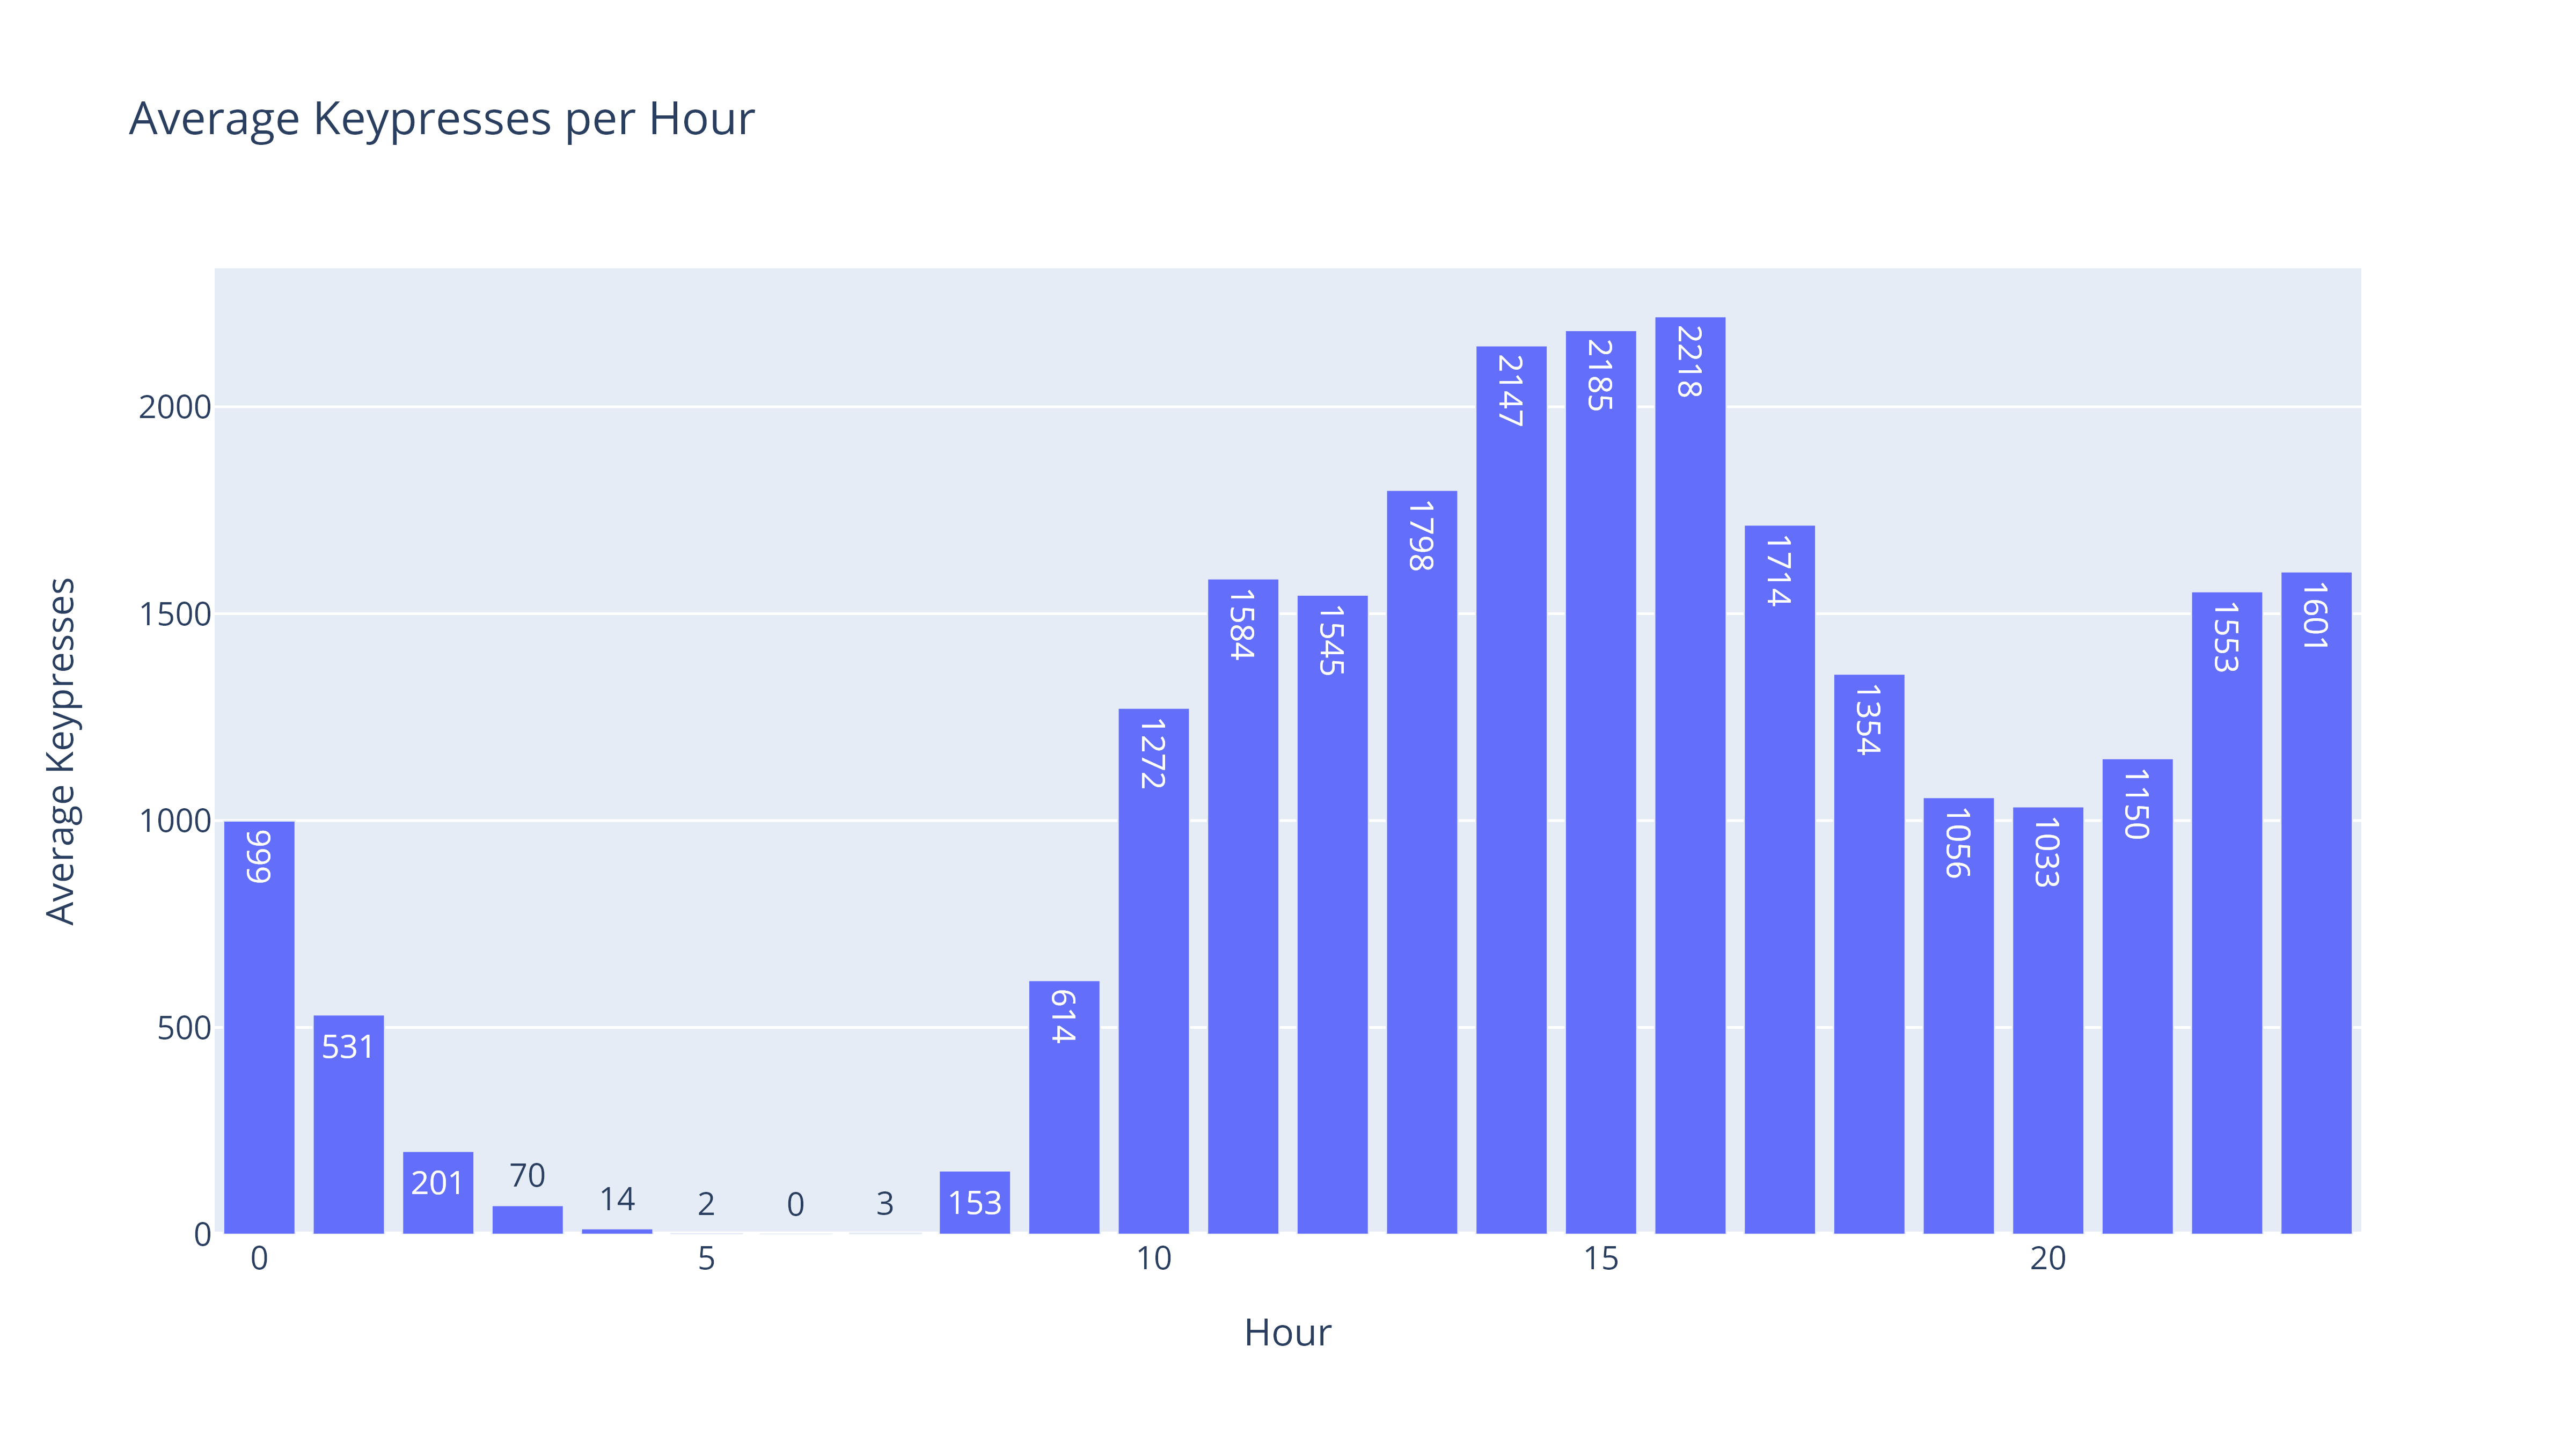

In [55]:
Image(static_graphs_folder+'average_keypresses_by_hour.png')

In [56]:
df_hourly_keypresses['Day'][0]

datetime.date(2020, 9, 21)

Saving the updated version of df_hourly_keypresses to a .csv file:

In [57]:
df_hourly_keypresses.to_csv('data/df_combined_hourly_keypresses_updated.csv')

## Data analysis question: Did marriage change my typing patterns?

I got married in April 2023, and I suspected that my keypress distributions as a married man might skew earlier than they did when I was a bachelor. I decided to investigate this graphically by creating subsets of df_hourly_keypresses that contained pre-marriage and post-marriage datasets, then comparing them via a grouped bar chart.

Setting datetime.date() values that will be used to filter df_hourly_keypresses:

In [58]:
post_mba_work_start_date = datetime.date(2022, 6, 21) # I began my current
# full-time work in June 2022 after finishing my MBA. I chose to limit the
# dataset to this date range so that my results wouldn't be influenced
# by my time as an MBA student (which featured more irregular computer hours).
last_day_before_marriage = datetime.date(2023, 4, 14)
day_after_honeymoon = datetime.date(2023, 4, 29) # I didn't type much at all
# on my honeymoon, so I excluded this period from my analysis in order not
# to skew the average keypress totals downward. 

In [59]:
df_hourly_keypresses_pre_marriage = df_hourly_keypresses.query(
"Day > @post_mba_work_start_date & Day <= @last_day_before_marriage"
).pivot_table(index = 'Hour', values = 'Keypresses', aggfunc = 'mean').reset_index()
df_hourly_keypresses_pre_marriage['Period'] = 'Pre-Marriage'

df_hourly_keypresses_post_marriage = df_hourly_keypresses.query(
    "Day >= @day_after_honeymoon").pivot_table(
        index = 'Hour', values = 'Keypresses', aggfunc = 'mean').reset_index()
df_hourly_keypresses_post_marriage['Period'] = 'Post-Marriage'

# Combining these two DataFrames together:
df_hourly_keypresses_by_period = pd.concat([df_hourly_keypresses_pre_marriage,
df_hourly_keypresses_post_marriage])

df_hourly_keypresses_by_period


Hour   Keypresses         Period
0      0   641.848485   Pre-Marriage
1      1   296.060606   Pre-Marriage
2      2    58.700337   Pre-Marriage
3      3    31.047138   Pre-Marriage
4      4     0.090909   Pre-Marriage
5      5     0.000000   Pre-Marriage
6      6     1.138047   Pre-Marriage
7      7     4.380471   Pre-Marriage
8      8    62.777778   Pre-Marriage
9      9   574.838384   Pre-Marriage
10    10  1439.505051   Pre-Marriage
11    11  1632.949495   Pre-Marriage
12    12  1639.750842   Pre-Marriage
13    13  1856.245791   Pre-Marriage
14    14  1962.851852   Pre-Marriage
15    15  2019.952862   Pre-Marriage
16    16  1950.003367   Pre-Marriage
17    17  1412.973064   Pre-Marriage
18    18   941.222222   Pre-Marriage
19    19   888.138047   Pre-Marriage
20    20   873.659933   Pre-Marriage
21    21  1083.676768   Pre-Marriage
22    22  1323.804714   Pre-Marriage
23    23  1364.552189   Pre-Marriage
0      0   235.180000  Post-Marriage
1      1     0.000000  Post-Marriage
2      2     0.000000  Post-Marriage
3      3     0.000000  Post-Marriage
4      4     0.000000  Post-Marriage
5      5     0.000000  Post-Marriage
6      6     0.000000  Post-Marriage
7      7     0.660000  Post-Marriage
8      8    59.520000  Post-Marriage
9      9   689.000000  Post-Marriage
10    10  1892.540000  Post-Marriage
11    11  2157.920000  Post-Marriage
12    12  1735.240000  Post-Marriage
13    13  1992.300000  Post-Marriage
14    14  2652.420000  Post-Marriage
15    15  2248.760000  Post-Marriage
16    16  1941.580000  Post-Marriage
17    17  1497.408163  Post-Marriage
18    18   854.836735  Post-Marriage
19    19  1122.897959  Post-Marriage
20    20   775.183673  Post-Marriage
21    21   766.693878  Post-Marriage
22    22   933.836735  Post-Marriage
23    23   569.244898  Post-Marriage

My overall number of keypresses is slightly higher post-marriage than pre-marriage:

In [60]:
df_hourly_keypresses_by_period.pivot_table(
    index = 'Period', values = 'Keypresses', aggfunc = 'sum')

Keypresses
Period                     
Post-Marriage  22125.222041
Pre-Marriage   22060.168350

However, as the following chart shows, the hourly distribution of these keypresses has changed significantly. I'm now typing much less late at night and am getting more keypresses in earlier in the day.

In [61]:
fig_keypresses_by_period = px.bar(df_hourly_keypresses_by_period, x = 'Hour', 
y = 'Keypresses', color = 'Period', barmode = 'group', text_auto = '.0f', 
title = 'Average Keypresses by Hour Before and After Getting Married')
save_chart(fig_keypresses_by_period, 'keypresses_before_and_after_marriage')
# See https://plotly.com/python/bar-charts/ 
# for the use of the 'color' and 'barmode' arguments.
fig_keypresses_by_period

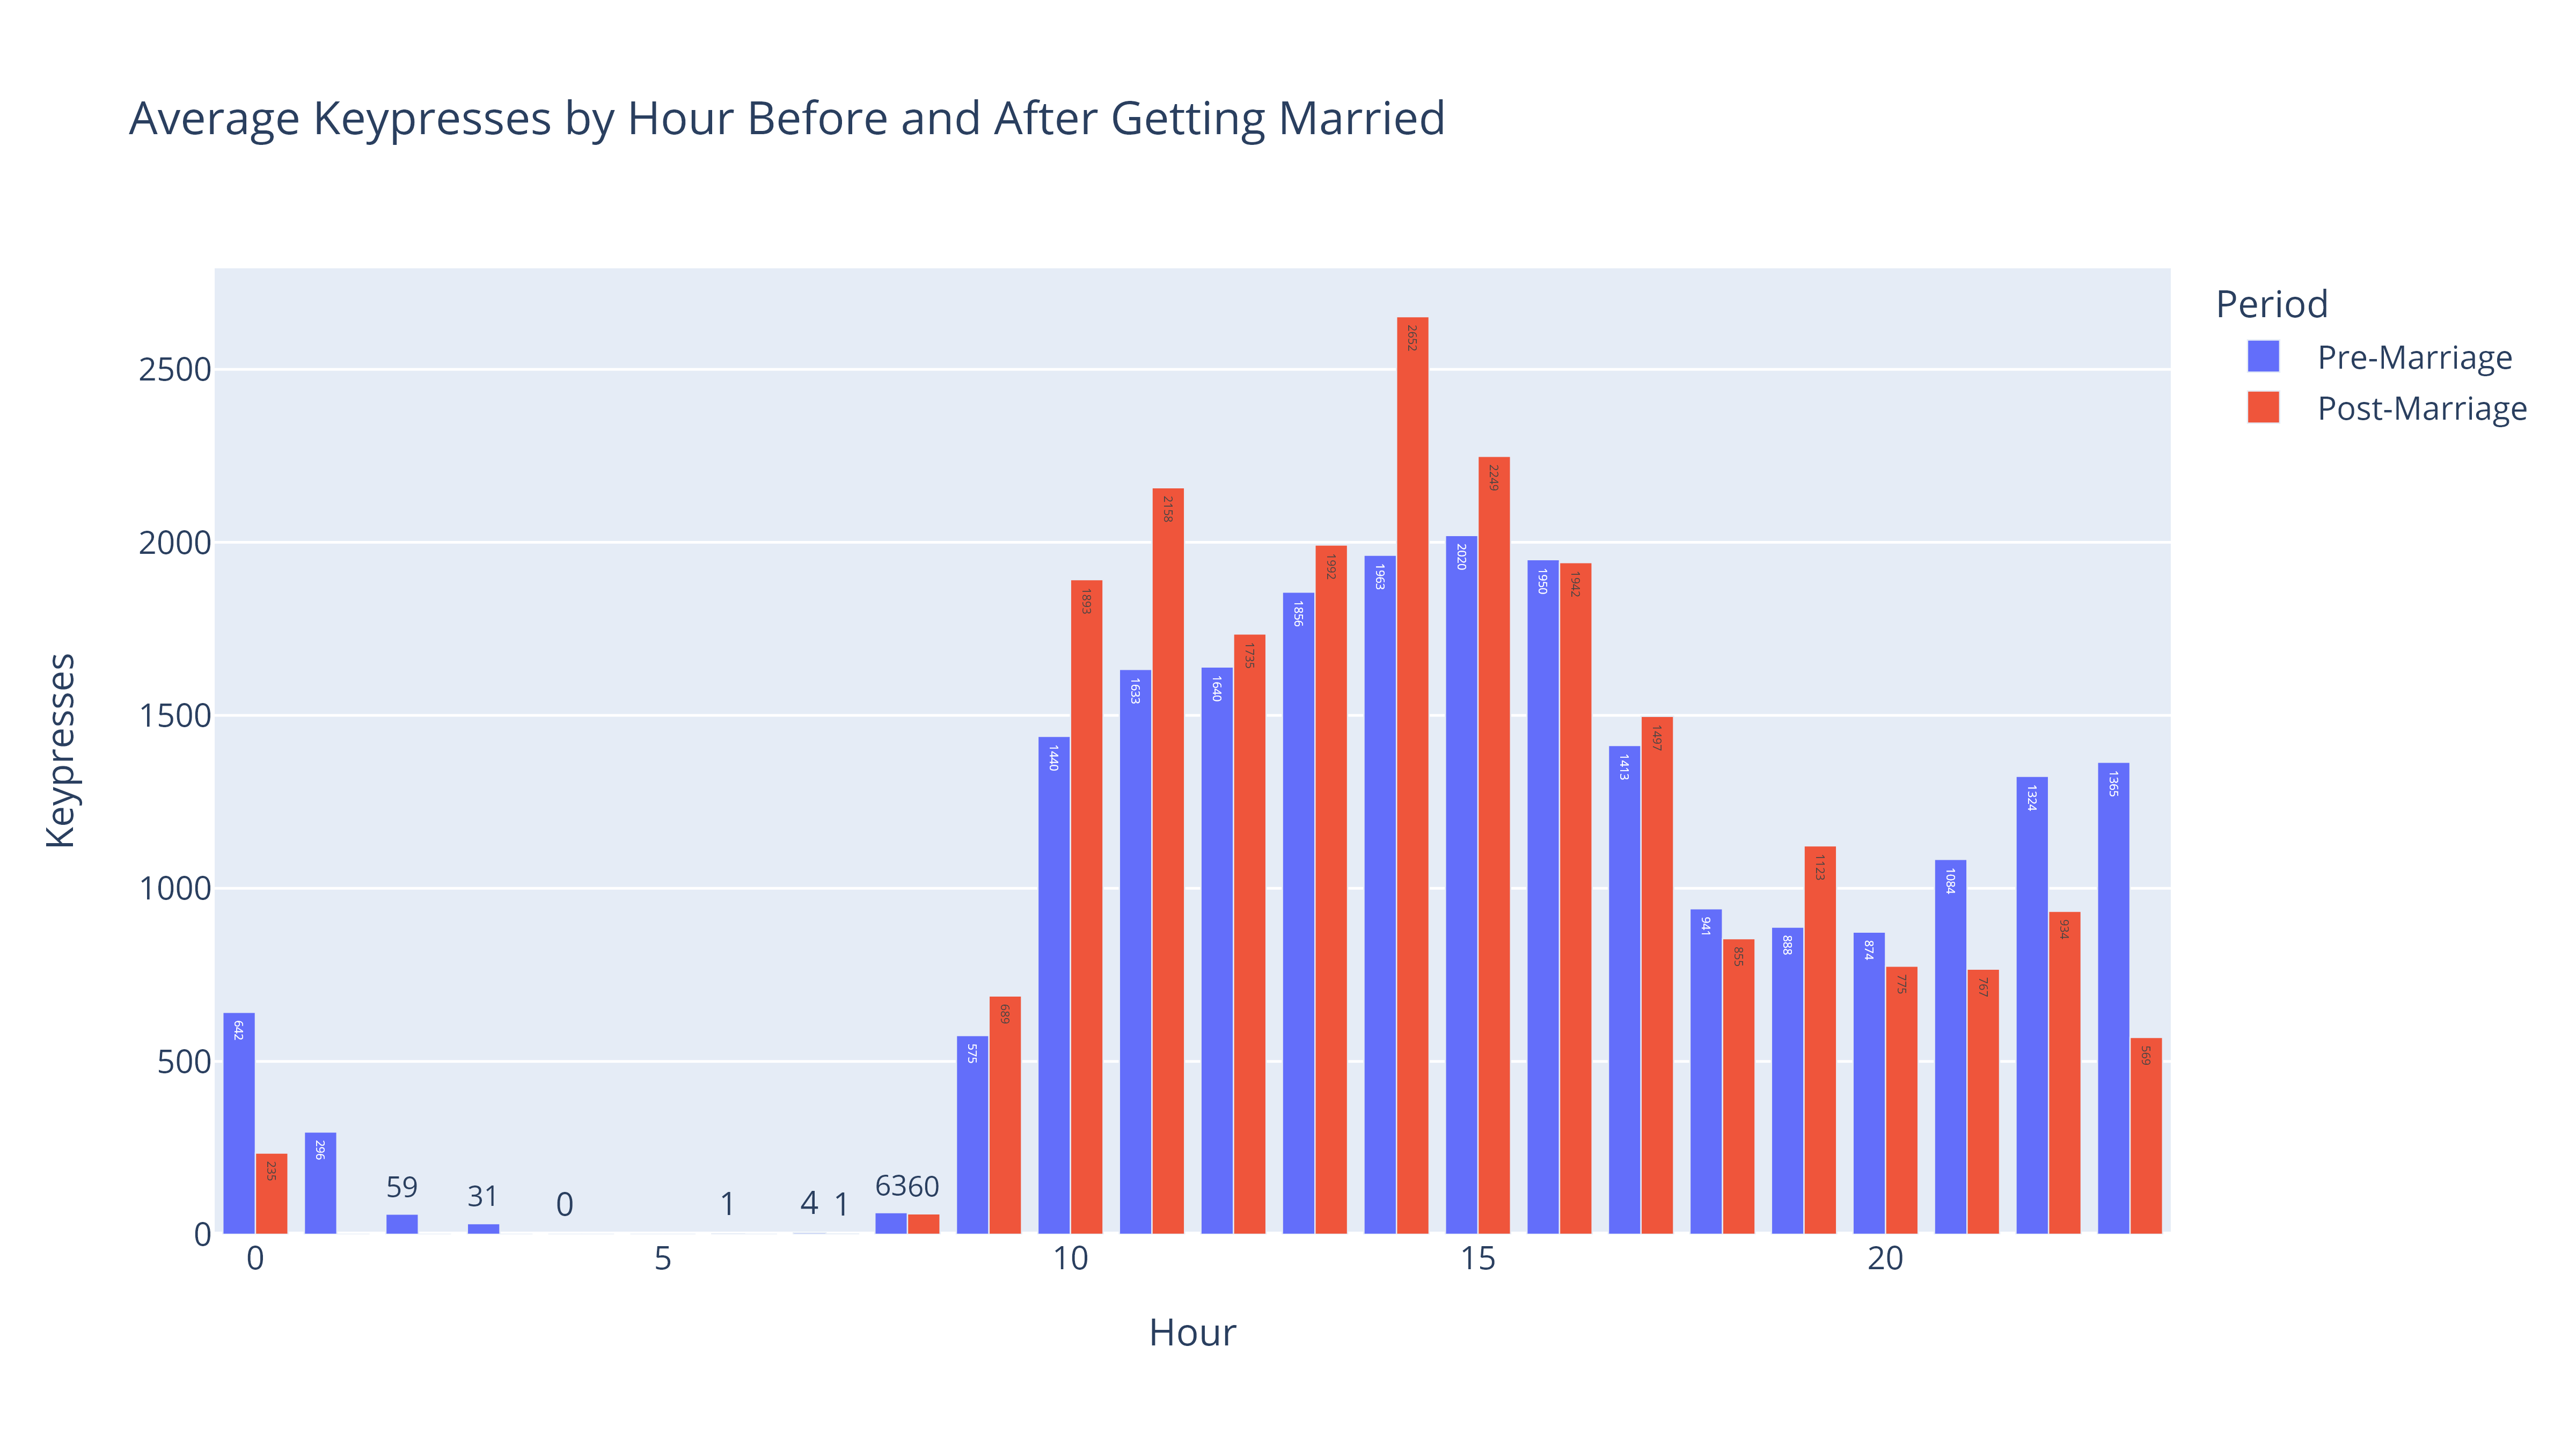

In [62]:
Image(static_graphs_folder+'keypresses_before_and_after_marriage.png')

In [63]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60

run_minutes, run_seconds


(0.0, 8.397568702697754)

The input() function within the following cell keeps the console window open when running the file in a command prompt. It's not necessary for the Jupyter Notebook, but when I export this notebook as a Python script and then run the script on a scheduled basis, this line gives me time to read the output.
See nosklo's response at: https://stackoverflow.com/a/1000968/13097194

In [64]:
print("The program has finished running. Press Enter to exit.") # Lets me know
# that I can now close the program after it has finished running in a console
# window. (I wouldn't want to close it while the 
# graphs are in the process of being generated.)
input() 


The program has finished running. Press Enter to exit.


''

That's it for this program! I hope you enjoy using it to analyze your own WhatPulse keypress statistics.